In [1]:
import sys
sys.path.append('../')
from PertQuant.simCRN.multivariate_reg import read_eq_data_file
from PertQuant.simCRN.multivariate_reg import convert_np2df
from PertQuant.simCRN.multivariate_reg import get_stats
from PertQuant.simCRN.multivariate_reg import Z_normalize_data
from PertQuant.simCRN.multivariate_reg import min_max_normalize
from PertQuant.simCRN.multivariate_reg import prep_data
from PertQuant.simCRN.multivariate_reg import plot_data
from PertQuant.simCRN.multivariate_reg import plot_predict
from PertQuant.simCRN.multivariate_reg import plot_true_and_pred
from PertQuant.simCRN.multivariate_reg import plot_error_hist
from PertQuant.simCRN.multivariate_reg import plot_true_v_error
from PertQuant.simCRN.multivariate_reg import plot_residuals
from PertQuant.simCRN.multivariate_reg import subset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LeakyReLU
import math
import numpy as np

In [2]:
# Read in data
Ci_all_array, Am_array, Cmin, Cmax, Ai = \
read_eq_data_file('4-4-2-semi-asym-AB-AC.txt')

In [3]:
# Prep data
Am_df, Ci_df, train_Am_df, train_Ci_df, test_Am_df, test_Ci_df = \
prep_data(Am_array, Ci_all_array, 0.8)

In [4]:
# Normalize data
train_Am_stats = get_stats(train_Am_df)
normed_train_Am_df = Z_normalize_data(train_Am_df, train_Am_stats)
normed_test_Am_df = Z_normalize_data(test_Am_df, train_Am_stats)
train_Ci_stats = get_stats(train_Ci_df)
normed_train_Ci_df = Z_normalize_data(train_Ci_df, train_Ci_stats)
normed_test_Ci_df = Z_normalize_data(test_Ci_df, train_Ci_stats)

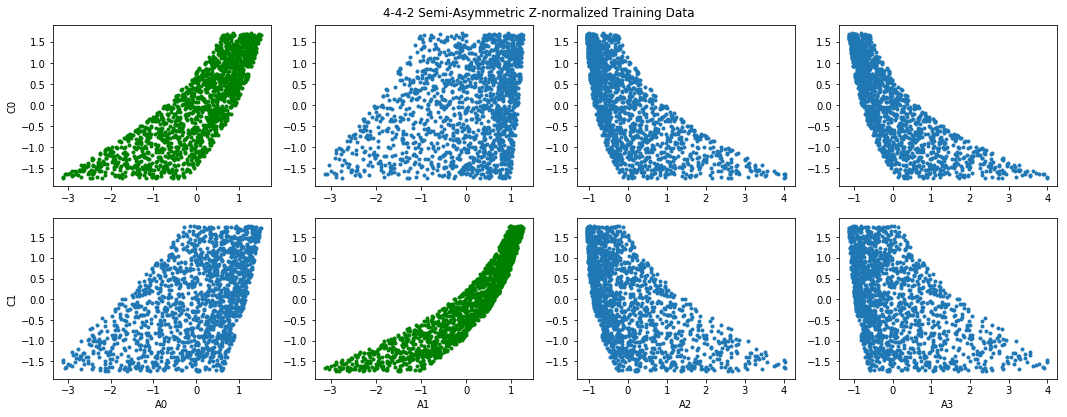

In [5]:
plot_data(normed_train_Am_df, normed_train_Ci_df, \
          title='4-4-2 Semi-Asymmetric Z-normalized Training Data')

(1.403e-07, 1.411e-07)

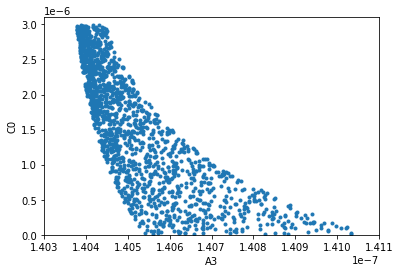

In [28]:
plt.scatter(train_Am_df['A3'],train_Ci_df['C0'], marker='.')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel('A3')
plt.ylabel('C0')
plt.ylim(0,3.1e-6)
plt.xlim(1.403e-7,1.411e-7)
# plt.xlim(0,1e-6)

(1.403e-07, 1.411e-07)

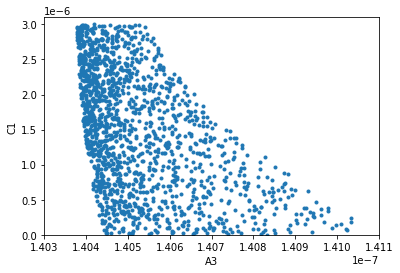

In [46]:
plt.scatter(train_Am_df['A3'],train_Ci_df['C1'], marker='.')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel('A3')
plt.ylabel('C1')
plt.ylim(0,3.1e-6)
plt.xlim(1.403e-7,1.411e-7)
# plt.xlim(0,1e-6)

(2.908e-07, 2.92e-07)

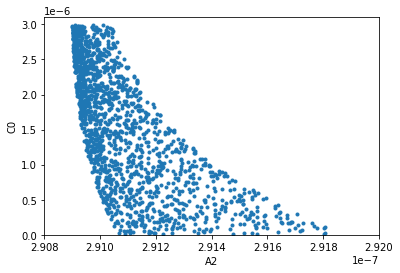

In [52]:
plt.scatter(train_Am_df['A2'],train_Ci_df['C0'], marker='.')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel('A2')
plt.ylabel('C0')
plt.ylim(0,3.1e-6)
plt.xlim(2.908e-7,2.92e-7)
# plt.xlim(0,1e-6)

(2.908e-07, 2.919e-07)

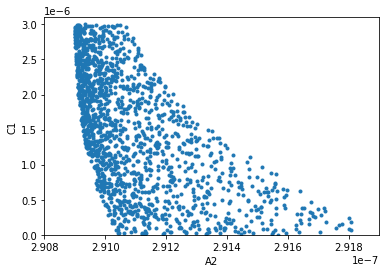

In [38]:
plt.scatter(train_Am_df['A2'],train_Ci_df['C1'], marker='.')
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
plt.xlabel('A2')
plt.ylabel('C1')
plt.ylim(0,3.1e-6)
plt.xlim(2.908e-7,2.919e-7)
# plt.xlim(0,1e-7)

In [11]:
EPOCHS = 1000
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

In [12]:
def build_model(num_nodes, num_layers, act_func):
    model = keras.Sequential()
    model.add(layers.Dense(num_nodes, activation=act_func, input_shape=[len(train_Am_df.keys())]))
    for i in range(num_layers - 1):
        model.add(layers.Dense(num_nodes, activation=act_func))
    model.add(layers.Dense(len(train_Ci_df.keys())))
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    return model

Let's test a 50 node, 1 layer model

In [13]:
model_50_1 = build_model(50,1, "relu")


Epoch: 0, loss:0.4433,  mae:0.5544,  mse:0.4433,  val_loss:0.3125,  val_mae:0.4598,  val_mse:0.3125,  
....................................................................................................
Epoch: 100, loss:0.0003,  mae:0.0129,  mse:0.0003,  val_loss:0.0005,  val_mae:0.0164,  val_mse:0.0005,  
....................................................................................................
Epoch: 200, loss:0.0003,  mae:0.0115,  mse:0.0003,  val_loss:0.0002,  val_mae:0.0096,  val_mse:0.0002,  
....................................................................................................
Epoch: 300, loss:0.0003,  mae:0.0118,  mse:0.0003,  val_loss:0.0001,  val_mae:0.0069,  val_mse:0.0001,  
....................................................................................................
Epoch: 400, loss:0.0003,  mae:0.0108,  mse:0.0003,  val_loss:0.0001,  val_mae:0.0085,  val_mse:0.0001,  
........................................................................

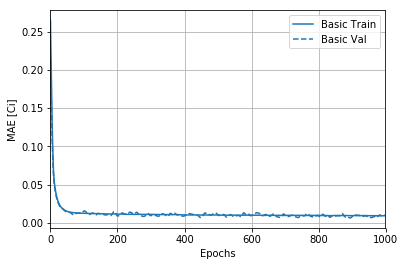

In [14]:
history_50_1 = model_50_1.fit(normed_train_Am_df, normed_train_Ci_df,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history_50_1}, metric = "mae")
plt.ylabel('MAE [Ci]')
plt.show()

In [15]:
loss_50_1, mae_50_1, mse_50_1 = \
model_50_1.evaluate(normed_test_Am_df, normed_test_Ci_df, verbose=2)

400/400 - 0s - loss: 4.4517e-04 - mae: 0.0167 - mse: 4.4517e-04


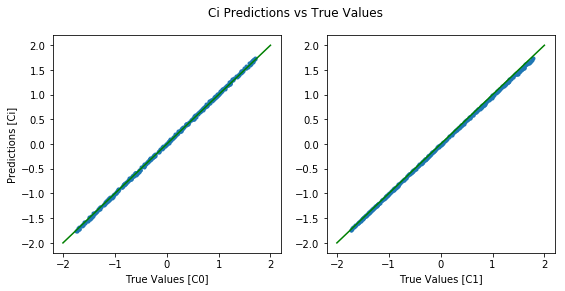

In [16]:
test_predictions_50_1 = model_50_1.predict(normed_test_Am_df)
plot_predict(test_predictions_50_1, normed_test_Ci_df, lims=[-2,2])

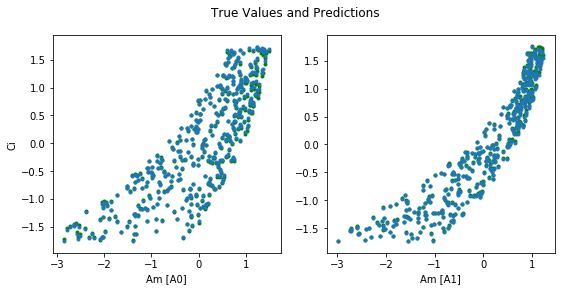

In [17]:
plot_true_and_pred(normed_test_Ci_df, test_predictions_50_1, normed_test_Am_df)

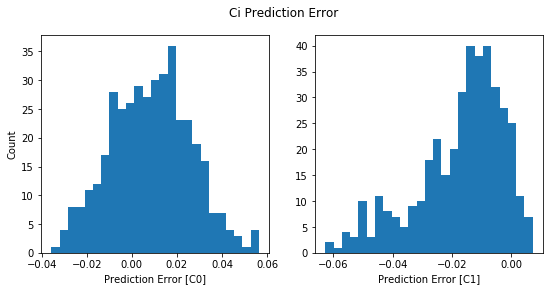

In [18]:
error_50_1 = test_predictions_50_1 - normed_test_Ci_df
plot_error_hist(error_50_1)

In [19]:
# Scaled MAE
scaled_mae_50_1 = error_50_1.abs().mean()*train_Ci_stats['std']
print(scaled_mae_50_1)

C0    1.385335e-08
C1    1.486108e-08
dtype: float64


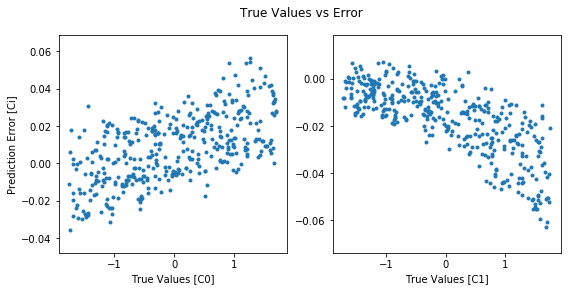

In [20]:
plot_true_v_error(normed_test_Ci_df, error_50_1)

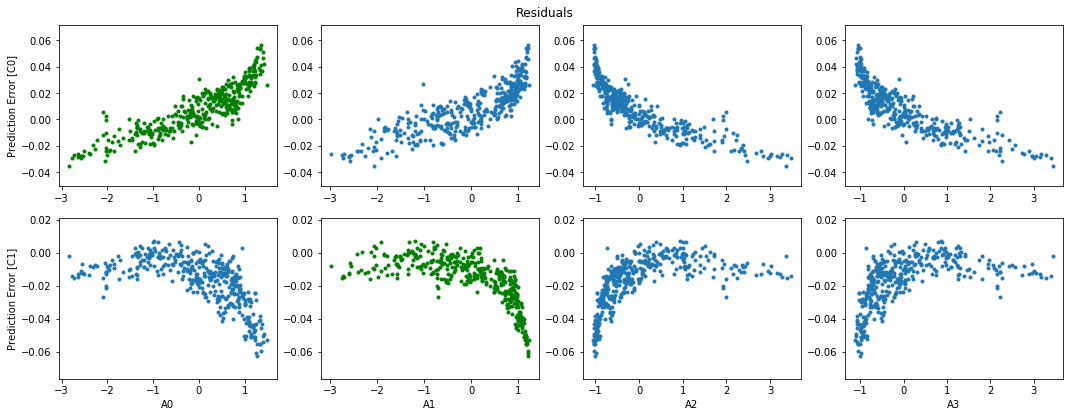

In [21]:
plot_residuals(normed_test_Am_df, error_50_1, green_list=[(0,0),(1,1),(2,2),(3,3)])

Now let's try using 1000 samples.

In [22]:
train_Am_df_50, train_Ci_df_50, test_Am_df_50, test_Ci_df_50, large_test_Am_df_50, \
        large_test_Ci_df_50 = subset(Am_df, Ci_df, 0.50, 0.8)

In [23]:
# Normalize data
train_Am_stats_50 = get_stats(train_Am_df_50)
normed_train_Am_df_50 = Z_normalize_data(train_Am_df_50, train_Am_stats_50)
normed_test_Am_df_50 = Z_normalize_data(test_Am_df_50, train_Am_stats_50)
large_normed_test_Am_df_50 = Z_normalize_data(large_test_Am_df_50, train_Am_stats_50)
train_Ci_stats_50 = get_stats(train_Ci_df_50)
normed_train_Ci_df_50 = Z_normalize_data(train_Ci_df_50, train_Ci_stats_50)
normed_test_Ci_df_50 = Z_normalize_data(test_Ci_df_50, train_Ci_stats_50)
large_normed_test_Ci_df_50 = Z_normalize_data(large_test_Ci_df_50, train_Ci_stats_50)

In [24]:
model_50_1_50 = build_model(50,1,"relu")


Epoch: 0, loss:0.8518,  mae:0.7738,  mse:0.8518,  val_loss:0.5847,  val_mae:0.6274,  val_mse:0.5847,  
....................................................................................................
Epoch: 100, loss:0.0005,  mae:0.0158,  mse:0.0005,  val_loss:0.0010,  val_mae:0.0243,  val_mse:0.0010,  
....................................................................................................
Epoch: 200, loss:0.0002,  mae:0.0105,  mse:0.0002,  val_loss:0.0019,  val_mae:0.0330,  val_mse:0.0019,  
....................................................................................................
Epoch: 300, loss:0.0003,  mae:0.0110,  mse:0.0003,  val_loss:0.0002,  val_mae:0.0104,  val_mse:0.0002,  
....................................................................................................
Epoch: 400, loss:0.0003,  mae:0.0109,  mse:0.0003,  val_loss:0.0001,  val_mae:0.0083,  val_mse:0.0001,  
........................................................................

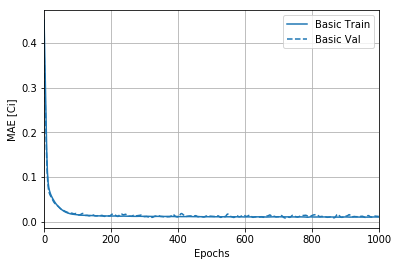

In [25]:
# The patience parameter is the amount of epochs to check for improvement
history = model_50_1_50.fit(normed_train_Am_df_50, normed_train_Ci_df_50,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history}, metric = "mae")
# plt.ylim([0, 1])
plt.ylabel('MAE [Ci]')
plt.show()

In [26]:
loss_50_1_50, mae_50_1_50, mse_50_1_50 = \
model_50_1_50.evaluate(normed_test_Am_df_50, normed_test_Ci_df_50, verbose=2)

200/200 - 0s - loss: 6.5803e-05 - mae: 0.0062 - mse: 6.5803e-05


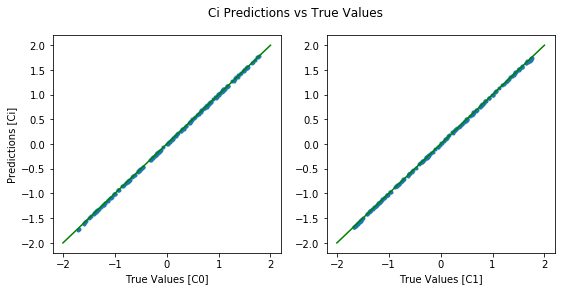

In [27]:
test_predictions_50_1_50 = model_50_1_50.predict(normed_test_Am_df_50)
plot_predict(test_predictions_50_1_50, normed_test_Ci_df_50, lims=[-2,2])

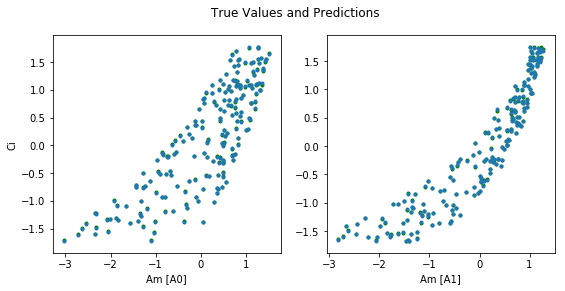

In [28]:
plot_true_and_pred(normed_test_Ci_df_50, test_predictions_50_1_50, normed_test_Am_df_50)

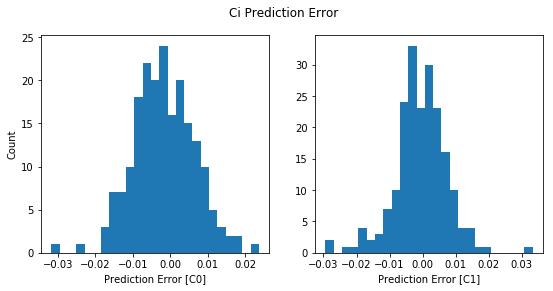

In [29]:
error_50_1_50 = test_predictions_50_1_50 - normed_test_Ci_df_50
plot_error_hist(error_50_1_50)

In [30]:
# Scaled MAE
scaled_mae_50_1_50 =error_50_1_50.abs().mean()*train_Ci_stats_50['std']
print(scaled_mae_50_1_50)

C0    5.608555e-09
C1    5.138670e-09
dtype: float64


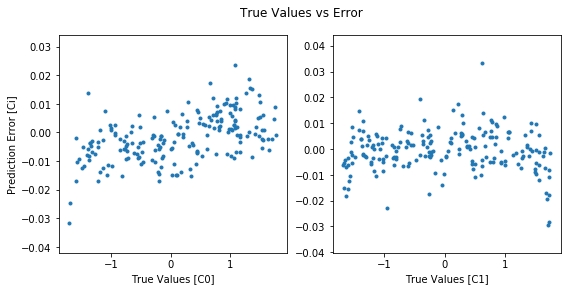

In [31]:
plot_true_v_error(normed_test_Ci_df_50, error_50_1_50)

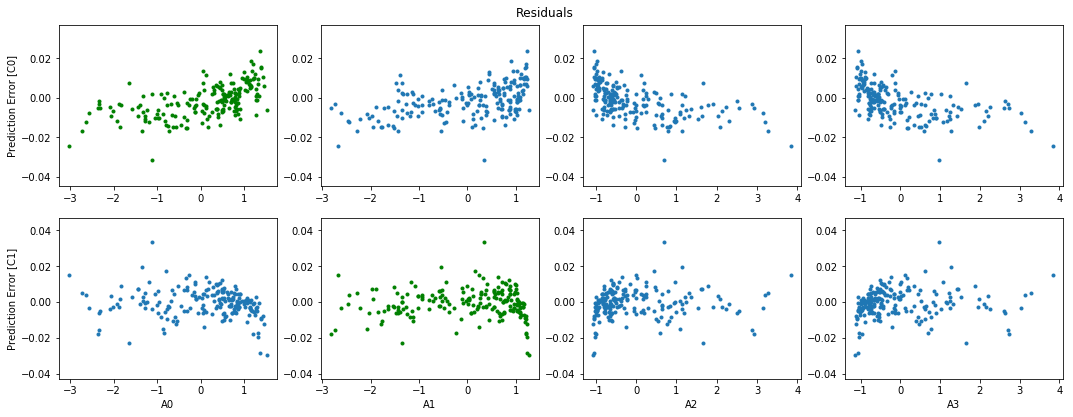

In [32]:
plot_residuals(normed_test_Am_df_50, error_50_1_50, green_list=[(0,0),(1,1),(2,2),(3,3)])

In [33]:
loss_50_1_50L, mae_50_1_50L, mse_50_1_50L = \
model_50_1_50.evaluate(large_normed_test_Am_df_50, large_normed_test_Ci_df_50, \
                        verbose=2)

1200/1200 - 0s - loss: 6.2202e-05 - mae: 0.0061 - mse: 6.2202e-05


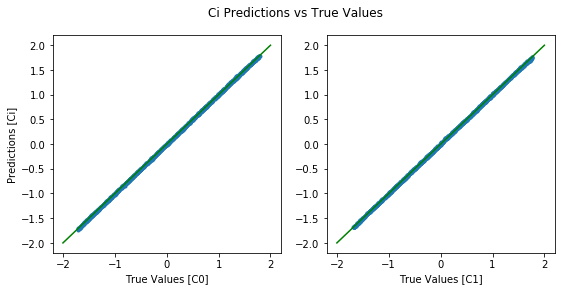

In [34]:
test_predictions_50_1_50L = model_50_1_50.predict(large_normed_test_Am_df_50)
plot_predict(test_predictions_50_1_50L, large_normed_test_Ci_df_50, lims=[-2,2])

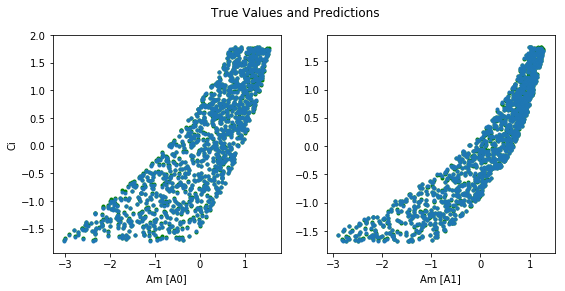

In [35]:
plot_true_and_pred(large_normed_test_Ci_df_50, test_predictions_50_1_50L, \
                   large_normed_test_Am_df_50)

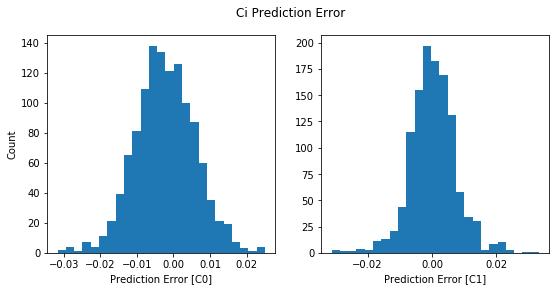

In [36]:
error_50_1_50L = test_predictions_50_1_50L - large_normed_test_Ci_df_50
plot_error_hist(error_50_1_50L)

In [37]:
# Scaled MAE
scaled_mae_50_1_50L = error_50_1_50L.abs().mean()*train_Ci_stats_50['std']
print(scaled_mae_50_1_50L)

C0    5.753707e-09
C1    4.706797e-09
dtype: float64


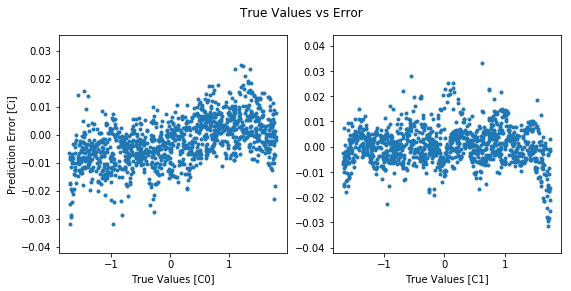

In [38]:
plot_true_v_error(large_normed_test_Ci_df_50, error_50_1_50L)

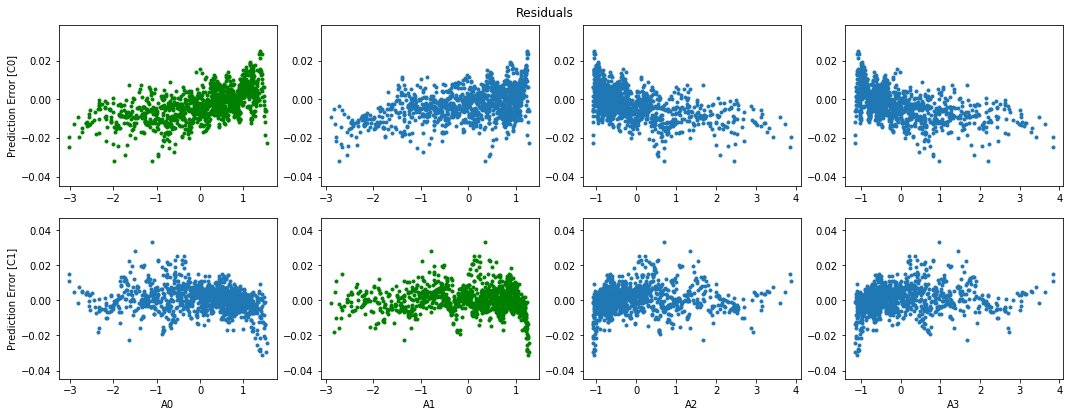

In [39]:
plot_residuals(large_normed_test_Am_df_50, error_50_1_50L, \
               green_list=[(0,0),(1,1),(2,2),(3,3)])

Now let's try 500 samples

In [40]:
train_Am_df_25, train_Ci_df_25, test_Am_df_25, test_Ci_df_25, large_test_Am_df_25, \
        large_test_Ci_df_25 = subset(Am_df, Ci_df, 0.25, 0.8)

In [41]:
# Normalize data
train_Am_stats_25 = get_stats(train_Am_df_25)
normed_train_Am_df_25 = Z_normalize_data(train_Am_df_25, train_Am_stats_25)
normed_test_Am_df_25 = Z_normalize_data(test_Am_df_25, train_Am_stats_25)
large_normed_test_Am_df_25 = Z_normalize_data(large_test_Am_df_25, train_Am_stats_25)
train_Ci_stats_25 = get_stats(train_Ci_df_25)
normed_train_Ci_df_25 = Z_normalize_data(train_Ci_df_25, train_Ci_stats_25)
normed_test_Ci_df_25 = Z_normalize_data(test_Ci_df_25, train_Ci_stats_25)
large_normed_test_Ci_df_25 = Z_normalize_data(large_test_Ci_df_25, train_Ci_stats_25)

In [42]:
model_50_1_25 = build_model(50,1,"relu")


Epoch: 0, loss:1.2053,  mae:0.9417,  mse:1.2053,  val_loss:1.0049,  val_mae:0.8554,  val_mse:1.0049,  
....................................................................................................
Epoch: 100, loss:0.0015,  mae:0.0299,  mse:0.0015,  val_loss:0.0024,  val_mae:0.0372,  val_mse:0.0024,  
....................................................................................................
Epoch: 200, loss:0.0006,  mae:0.0177,  mse:0.0006,  val_loss:0.0014,  val_mae:0.0286,  val_mse:0.0014,  
....................................................................................................
Epoch: 300, loss:0.0004,  mae:0.0142,  mse:0.0004,  val_loss:0.0005,  val_mae:0.0185,  val_mse:0.0005,  
....................................................................................................
Epoch: 400, loss:0.0004,  mae:0.0156,  mse:0.0004,  val_loss:0.0004,  val_mae:0.0154,  val_mse:0.0004,  
........................................................................

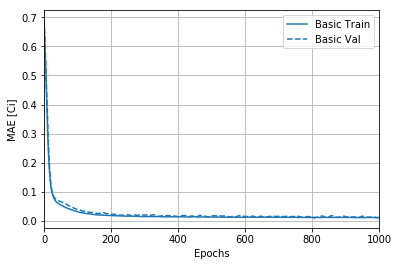

In [43]:
# The patience parameter is the amount of epochs to check for improvement
history = model_50_1_25.fit(normed_train_Am_df_25, normed_train_Ci_df_25,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history}, metric = "mae")
# plt.ylim([0, 1])
plt.ylabel('MAE [Ci]')
plt.show()

In [44]:
loss_50_1_25, mae_50_1_25, mse_50_1_25 = \
model_50_1_25.evaluate(normed_test_Am_df_25, normed_test_Ci_df_25, verbose=2)

100/100 - 0s - loss: 2.3712e-04 - mae: 0.0109 - mse: 2.3712e-04


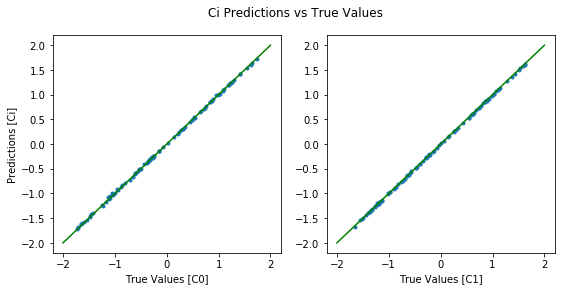

In [45]:
test_predictions_50_1_25 = model_50_1_25.predict(normed_test_Am_df_25)
plot_predict(test_predictions_50_1_25, normed_test_Ci_df_25, lims=[-2,2])

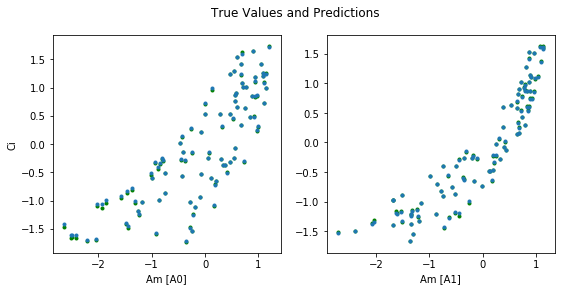

In [46]:
plot_true_and_pred(normed_test_Ci_df_25, test_predictions_50_1_25, normed_test_Am_df_25)

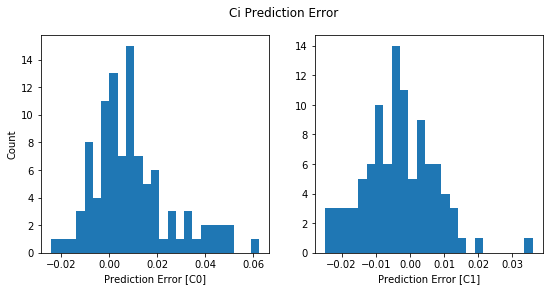

In [47]:
error_50_1_25 = test_predictions_50_1_25 - normed_test_Ci_df_25
plot_error_hist(error_50_1_25)

In [48]:
# Scaled MAE
scaled_mae_50_1_25 = error_50_1_25.abs().mean()*train_Ci_stats_25['std']
print(scaled_mae_50_1_25)

C0    1.154680e-08
C1    7.448193e-09
dtype: float64


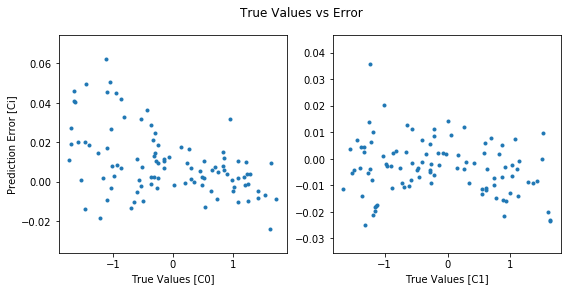

In [49]:
plot_true_v_error(normed_test_Ci_df_25, error_50_1_25)

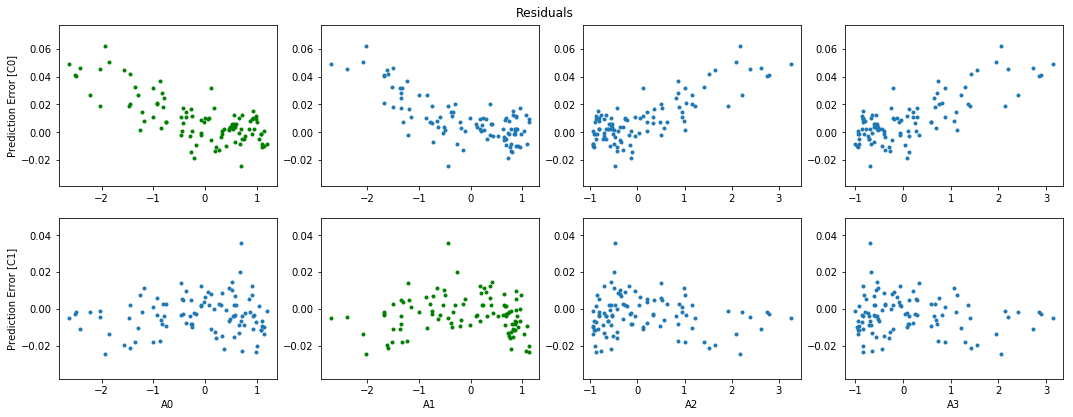

In [50]:
plot_residuals(normed_test_Am_df_25, error_50_1_25, green_list=[(0,0),(1,1),(2,2),(3,3)])

In [51]:
loss_50_1_25L, mae_50_1_25L, mse_50_1_25L = \
model_50_1_25.evaluate(large_normed_test_Am_df_25, large_normed_test_Ci_df_25, \
                        verbose=2)

1600/1600 - 0s - loss: 1.8539e-04 - mae: 0.0095 - mse: 1.8539e-04


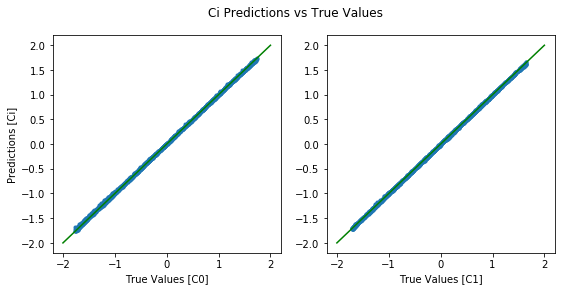

In [52]:
test_predictions_50_1_25L = model_50_1_25.predict(large_normed_test_Am_df_25)
plot_predict(test_predictions_50_1_25L, large_normed_test_Ci_df_25, lims=[-2,2])

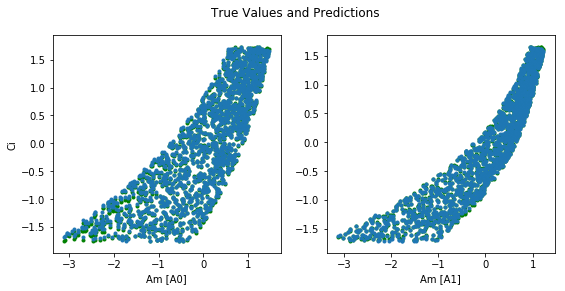

In [53]:
plot_true_and_pred(large_normed_test_Ci_df_25, test_predictions_50_1_25L, \
                   large_normed_test_Am_df_25)

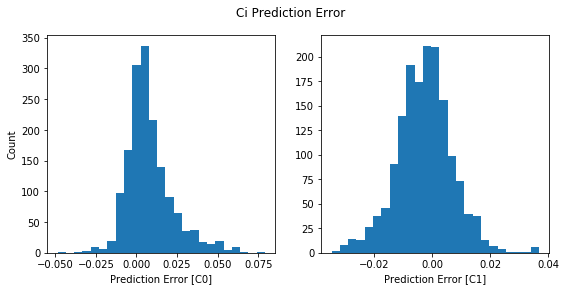

In [54]:
error_50_1_25L = test_predictions_50_1_25L - large_normed_test_Ci_df_25
plot_error_hist(error_50_1_25L)

In [55]:
# Scaled MAE
scaled_mae_50_1_25L = error_50_1_25L.abs().mean()*train_Ci_stats_25['std']
print(scaled_mae_50_1_25L)

C0    9.776591e-09
C1    6.822807e-09
dtype: float64


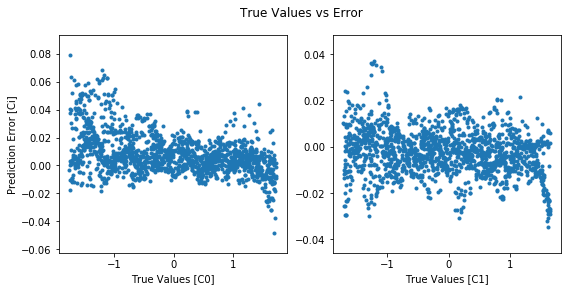

In [56]:
plot_true_v_error(large_normed_test_Ci_df_25, error_50_1_25L)

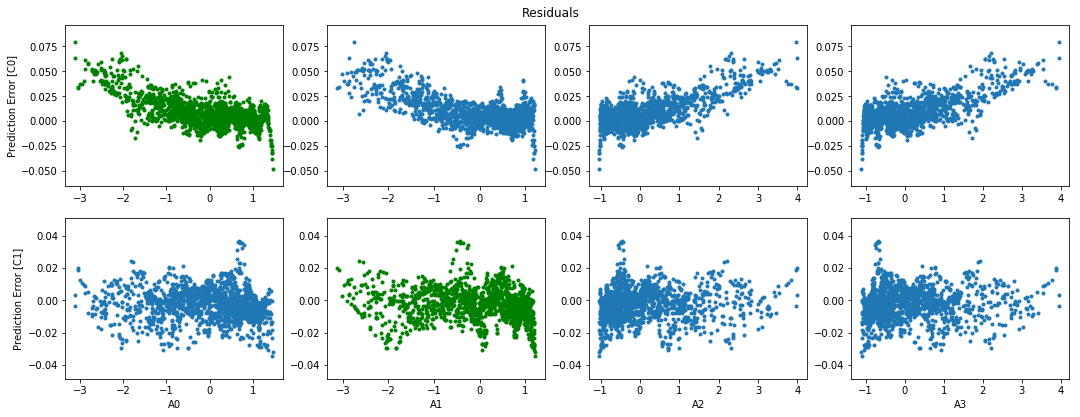

In [57]:
plot_residuals(large_normed_test_Am_df_25, error_50_1_25L, \
               green_list=[(0,0),(1,1),(2,2),(3,3)])

Now let's try looking at a data set of 250 samples

In [58]:
train_Am_df_125, train_Ci_df_125, test_Am_df_125, test_Ci_df_125, large_test_Am_df_125, \
        large_test_Ci_df_125 = subset(Am_df, Ci_df, 0.125, 0.8)

In [59]:
# Normalize data
train_Am_stats_125 = get_stats(train_Am_df_125)
normed_train_Am_df_125 = Z_normalize_data(train_Am_df_125, train_Am_stats_125)
normed_test_Am_df_125 = Z_normalize_data(test_Am_df_125, train_Am_stats_125)
large_normed_test_Am_df_125 = Z_normalize_data(large_test_Am_df_125, train_Am_stats_125)
train_Ci_stats_125 = get_stats(train_Ci_df_125)
normed_train_Ci_df_125 = Z_normalize_data(train_Ci_df_125, train_Ci_stats_125)
normed_test_Ci_df_125 = Z_normalize_data(test_Ci_df_125, train_Ci_stats_125)
large_normed_test_Ci_df_125 = Z_normalize_data(large_test_Ci_df_125, train_Ci_stats_125)

In [60]:
model_50_1_125 = build_model(50,1,"relu")


Epoch: 0, loss:0.9109,  mae:0.8039,  mse:0.9109,  val_loss:0.8529,  val_mae:0.7870,  val_mse:0.8529,  
....................................................................................................
Epoch: 100, loss:0.0054,  mae:0.0554,  mse:0.0054,  val_loss:0.0075,  val_mae:0.0633,  val_mse:0.0075,  
....................................................................................................
Epoch: 200, loss:0.0012,  mae:0.0261,  mse:0.0012,  val_loss:0.0028,  val_mae:0.0384,  val_mse:0.0028,  
....................................................................................................
Epoch: 300, loss:0.0006,  mae:0.0187,  mse:0.0006,  val_loss:0.0009,  val_mae:0.0235,  val_mse:0.0009,  
....................................................................................................
Epoch: 400, loss:0.0004,  mae:0.0154,  mse:0.0004,  val_loss:0.0011,  val_mae:0.0266,  val_mse:0.0011,  
........................................................................

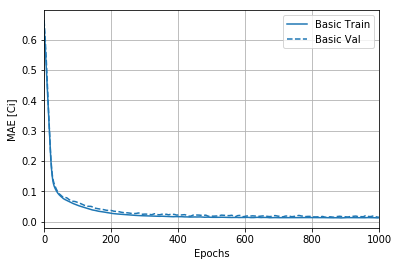

In [61]:
# The patience parameter is the amount of epochs to check for improvement
history = model_50_1_125.fit(normed_train_Am_df_125, normed_train_Ci_df_125,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history}, metric = "mae")
# plt.ylim([0, 1])
plt.ylabel('MAE [Ci]')
plt.show()

In [62]:
loss_50_1_125, mae_50_1_125, mse_50_1_125 = \
model_50_1_125.evaluate(normed_test_Am_df_125, normed_test_Ci_df_125, verbose=2)

50/50 - 0s - loss: 1.9302e-04 - mae: 0.0110 - mse: 1.9302e-04


In [63]:
# Scaled MAE
test_predictions_50_1_125 = model_50_1_125.predict(normed_test_Am_df_125)
error_50_1_125 = test_predictions_50_1_125 - normed_test_Ci_df_125
scaled_mae_50_1_125 = error_50_1_125.abs().mean()*train_Ci_stats_125['std']
print(scaled_mae_50_1_125)

C0    8.672584e-09
C1    1.053707e-08
dtype: float64


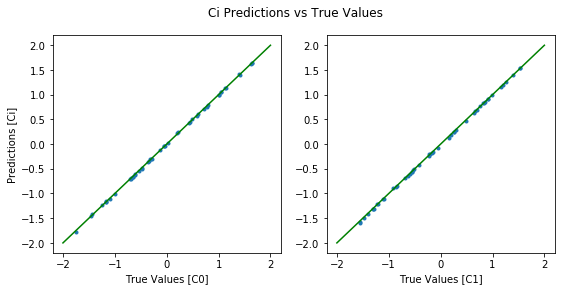

In [64]:
plot_predict(test_predictions_50_1_125, normed_test_Ci_df_125, lims=[-2,2])

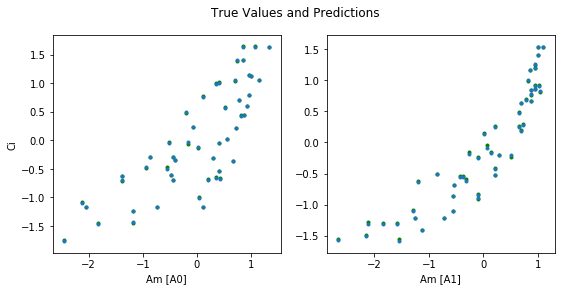

In [65]:
plot_true_and_pred(normed_test_Ci_df_125, test_predictions_50_1_125, normed_test_Am_df_125)

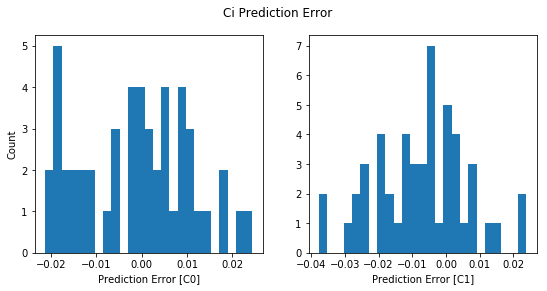

In [66]:
plot_error_hist(error_50_1_125)

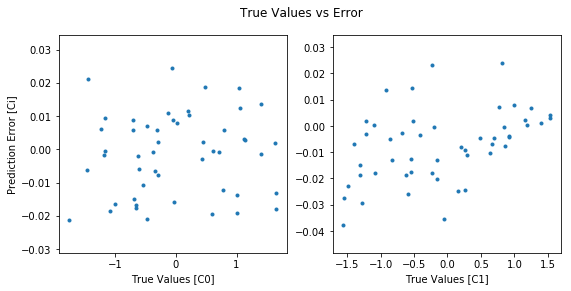

In [67]:
plot_true_v_error(normed_test_Ci_df_125, error_50_1_125)

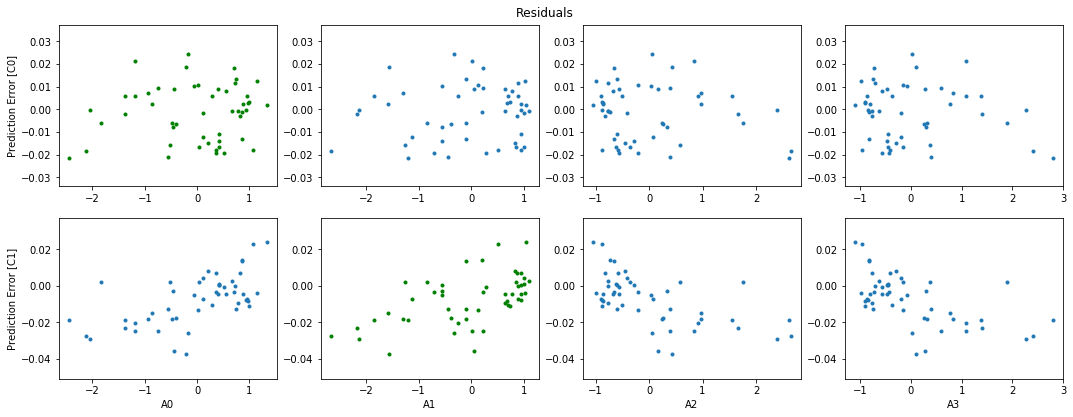

In [68]:
plot_residuals(normed_test_Am_df_125, error_50_1_125, green_list=[(0,0),(1,1),(2,2),(3,3)])

In [69]:
loss_50_1_125L, mae_50_1_125L, mse_50_1_125L = \
model_50_1_125.evaluate(large_normed_test_Am_df_125, large_normed_test_Ci_df_125, \
                        verbose=2)

1800/1800 - 0s - loss: 2.8616e-04 - mae: 0.0127 - mse: 2.8616e-04


In [70]:
# Scaled MAE
test_predictions_50_1_125L = model_50_1_125.predict(large_normed_test_Am_df_125)
error_50_1_125L = test_predictions_50_1_125L - large_normed_test_Ci_df_125
scaled_mae_50_1_125L = error_50_1_125L.abs().mean()*train_Ci_stats_125['std']
print(scaled_mae_50_1_125L)

C0    1.020626e-08
C1    1.196572e-08
dtype: float64


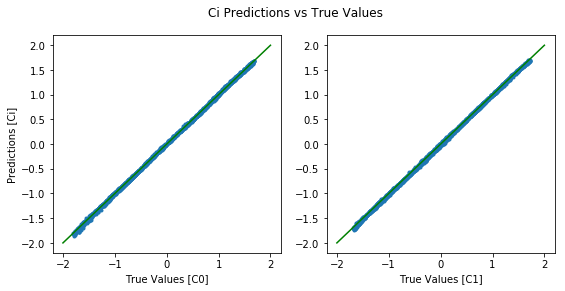

In [71]:
plot_predict(test_predictions_50_1_125L, large_normed_test_Ci_df_125, lims=[-2,2])

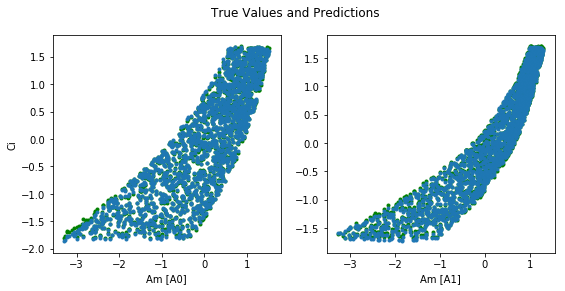

In [72]:
plot_true_and_pred(large_normed_test_Ci_df_125, test_predictions_50_1_125L, \
                   large_normed_test_Am_df_125)

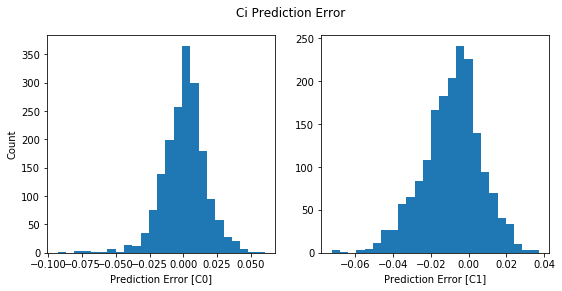

In [73]:
plot_error_hist(error_50_1_125L)

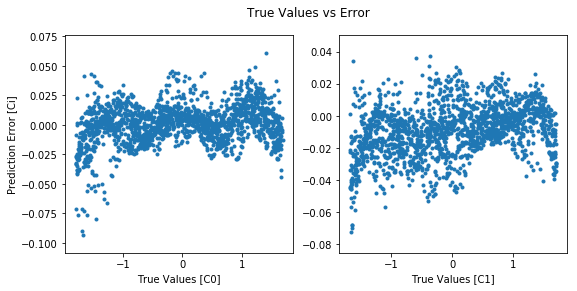

In [74]:
plot_true_v_error(large_normed_test_Ci_df_125, error_50_1_125L)

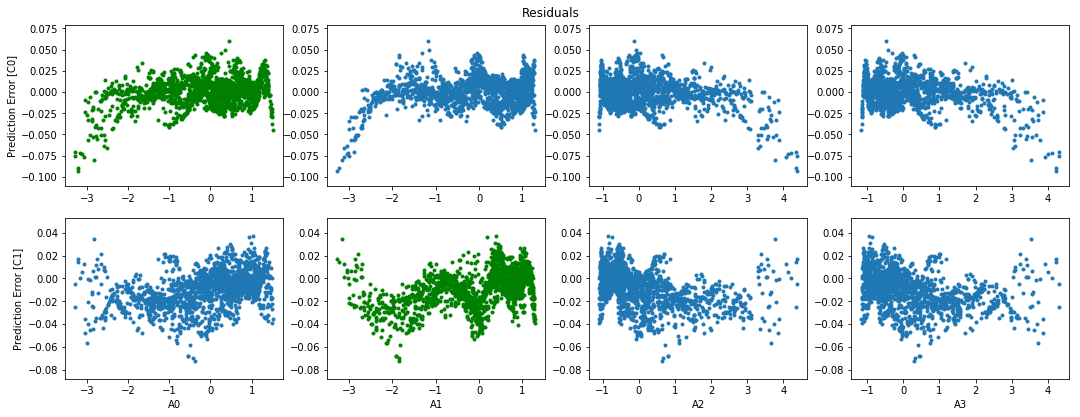

In [75]:
plot_residuals(large_normed_test_Am_df_125, error_50_1_125L, \
               green_list=[(0,0),(1,1),(2,2),(3,3)])

Now let's try 125 samples.

In [76]:
train_Am_df_05, train_Ci_df_05, test_Am_df_05, test_Ci_df_05, large_test_Am_df_05, \
        large_test_Ci_df_05 = subset(Am_df, Ci_df, 0.0625, 0.8)

In [77]:
# Normalize data
train_Am_stats_05 = get_stats(train_Am_df_05)
normed_train_Am_df_05 = Z_normalize_data(train_Am_df_05, train_Am_stats_05)
normed_test_Am_df_05 = Z_normalize_data(test_Am_df_05, train_Am_stats_05)
large_normed_test_Am_df_05 = Z_normalize_data(large_test_Am_df_05, train_Am_stats_05)
train_Ci_stats_05 = get_stats(train_Ci_df_05)
normed_train_Ci_df_05 = Z_normalize_data(train_Ci_df_05, train_Ci_stats_05)
normed_test_Ci_df_05 = Z_normalize_data(test_Ci_df_05, train_Ci_stats_05)
large_normed_test_Ci_df_05 = Z_normalize_data(large_test_Ci_df_05, train_Ci_stats_05)

In [78]:
model_50_1_05 = build_model(50,1,"relu")


Epoch: 0, loss:0.6228,  mae:0.6585,  mse:0.6228,  val_loss:0.8825,  val_mae:0.8174,  val_mse:0.8825,  
....................................................................................................
Epoch: 100, loss:0.0093,  mae:0.0690,  mse:0.0093,  val_loss:0.0129,  val_mae:0.0751,  val_mse:0.0129,  
....................................................................................................
Epoch: 200, loss:0.0038,  mae:0.0425,  mse:0.0038,  val_loss:0.0043,  val_mae:0.0417,  val_mse:0.0043,  
....................................................................................................
Epoch: 300, loss:0.0017,  mae:0.0300,  mse:0.0017,  val_loss:0.0038,  val_mae:0.0385,  val_mse:0.0038,  
....................................................................................................
Epoch: 400, loss:0.0010,  mae:0.0224,  mse:0.0010,  val_loss:0.0026,  val_mae:0.0325,  val_mse:0.0026,  
........................................................................

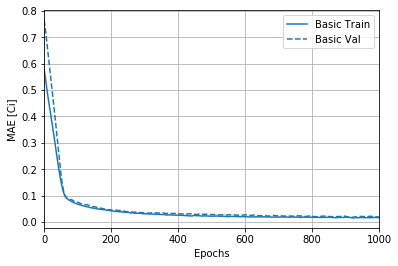

In [79]:
# The patience parameter is the amount of epochs to check for improvement
history = model_50_1_05.fit(normed_train_Am_df_05, normed_train_Ci_df_05,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [Ci]')
plt.show()

In [80]:
loss_50_1_05, mae_50_1_05, mse_50_1_05 = \
model_50_1_05.evaluate(normed_test_Am_df_05, normed_test_Ci_df_05, verbose=2)

25/25 - 0s - loss: 6.3382e-04 - mae: 0.0184 - mse: 6.3382e-04


In [81]:
# Scaled MAE
test_predictions_50_1_05 = model_50_1_05.predict(normed_test_Am_df_05)
error_50_1_05 = test_predictions_50_1_05 - normed_test_Ci_df_05
scaled_mae_50_1_05 = error_50_1_05.abs().mean()*train_Ci_stats_05['std']
print(scaled_mae_50_1_05)

C0    1.601535e-08
C1    1.564466e-08
dtype: float64


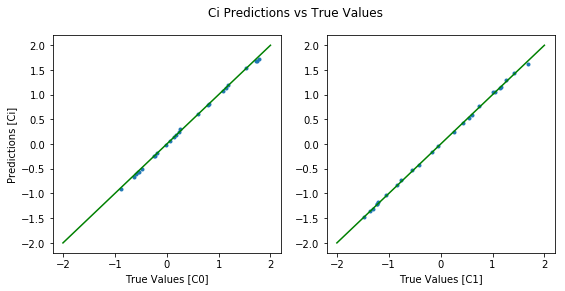

In [82]:
plot_predict(test_predictions_50_1_05, normed_test_Ci_df_05, lims=[-2,2])

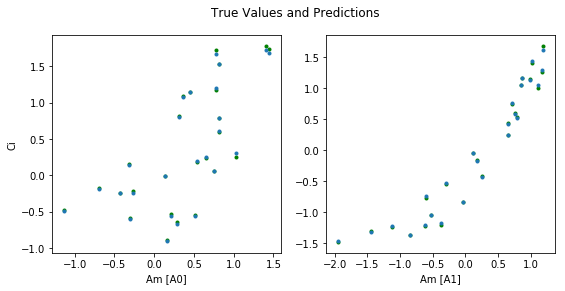

In [83]:
plot_true_and_pred(normed_test_Ci_df_05, test_predictions_50_1_05, normed_test_Am_df_05)

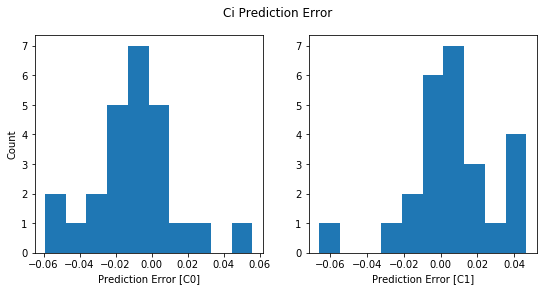

In [84]:
plot_error_hist(error_50_1_05, bins=10)

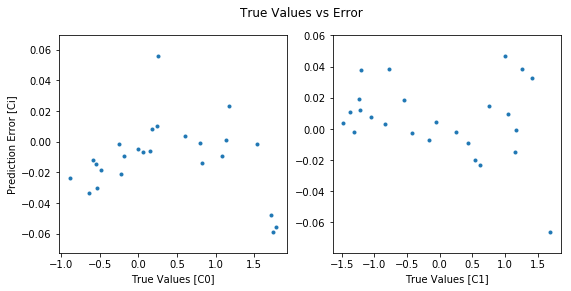

In [85]:
plot_true_v_error(normed_test_Ci_df_05, error_50_1_05)

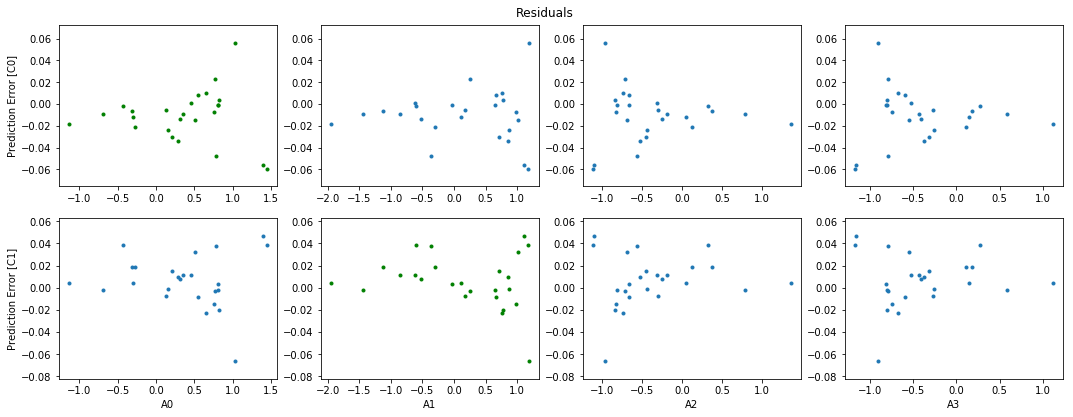

In [86]:
plot_residuals(normed_test_Am_df_05, error_50_1_05, green_list=[(0,0),(1,1),(2,2),(3,3)])

In [87]:
loss_50_1_05L, mae_50_1_05L, mse_50_1_05L = \
model_50_1_05.evaluate(large_normed_test_Am_df_05, large_normed_test_Ci_df_05, \
                        verbose=2)

1900/1900 - 0s - loss: 6.2700e-04 - mae: 0.0186 - mse: 6.2700e-04


In [88]:
# Scaled MAE
test_predictions_50_1_05L = model_50_1_05.predict(large_normed_test_Am_df_05)
error_50_1_05L = test_predictions_50_1_05L - large_normed_test_Ci_df_05
scaled_mae_50_1_05L = error_50_1_05L.abs().mean()*train_Ci_stats_05['std']
print(scaled_mae_50_1_05L)

C0    1.439500e-08
C1    1.774404e-08
dtype: float64


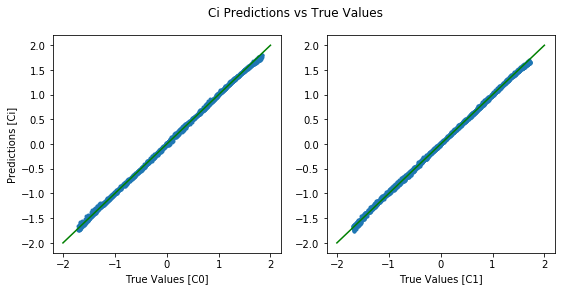

In [89]:
plot_predict(test_predictions_50_1_05L, large_normed_test_Ci_df_05, lims=[-2,2])

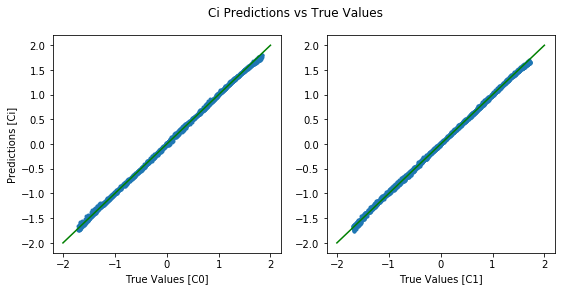

In [90]:
plot_predict(test_predictions_50_1_05L, large_normed_test_Ci_df_05, lims=[-2,2])

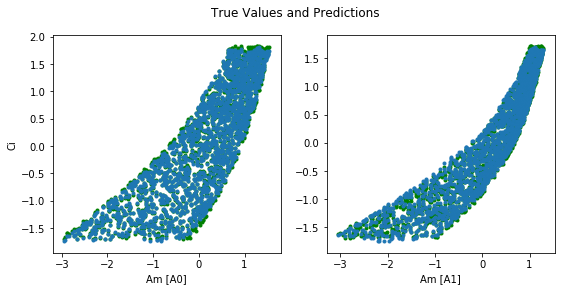

In [91]:
plot_true_and_pred(large_normed_test_Ci_df_05, test_predictions_50_1_05L, \
                   large_normed_test_Am_df_05)

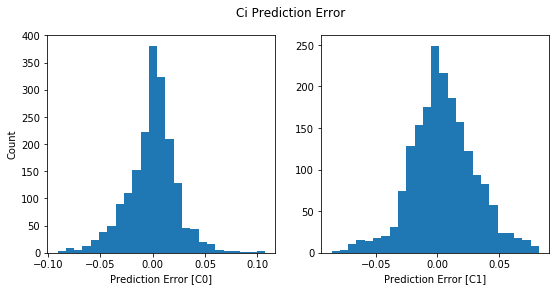

In [92]:
plot_error_hist(error_50_1_05L)

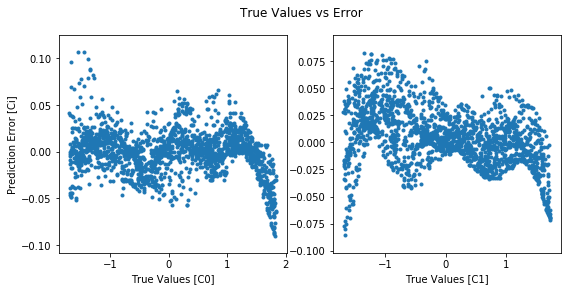

In [93]:
plot_true_v_error(large_normed_test_Ci_df_05, error_50_1_05L)

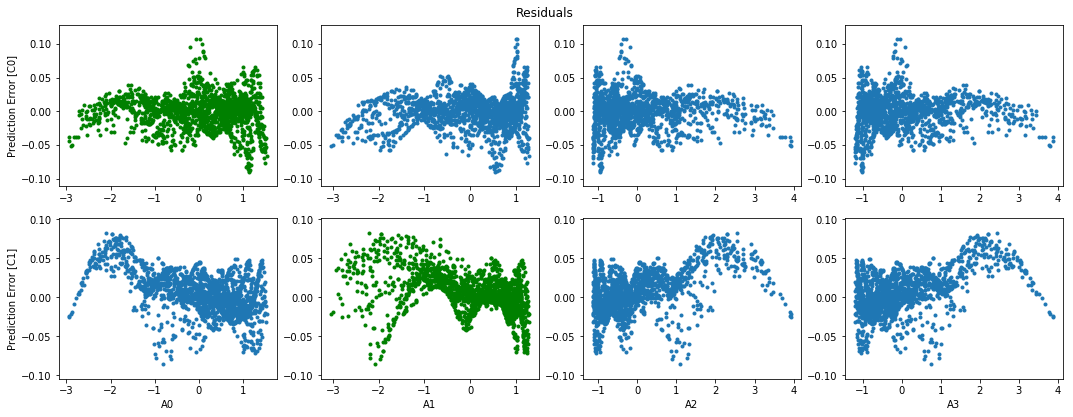

In [94]:
plot_residuals(large_normed_test_Am_df_05, error_50_1_05L, \
               green_list=[(0,0),(1,1),(2,2),(3,3)])

Now let's try 50 samples

In [95]:
train_Am_df_025, train_Ci_df_025, test_Am_df_025, test_Ci_df_025, large_test_Am_df_025, \
        large_test_Ci_df_025 = subset(Am_df, Ci_df, 0.025, 0.8)

In [96]:
# Normalize data
train_Am_stats_025 = get_stats(train_Am_df_025)
normed_train_Am_df_025 = Z_normalize_data(train_Am_df_025, train_Am_stats_025)
normed_test_Am_df_025 = Z_normalize_data(test_Am_df_025, train_Am_stats_025)
large_normed_test_Am_df_025 = Z_normalize_data(large_test_Am_df_025, train_Am_stats_025)
train_Ci_stats_025 = get_stats(train_Ci_df_025)
normed_train_Ci_df_025 = Z_normalize_data(train_Ci_df_025, train_Ci_stats_025)
normed_test_Ci_df_025 = Z_normalize_data(test_Ci_df_025, train_Ci_stats_025)
large_normed_test_Ci_df_025 = Z_normalize_data(large_test_Ci_df_025, train_Ci_stats_025)

In [97]:
model_50_1_025 = build_model(50,1,"relu")


Epoch: 0, loss:1.2374,  mae:0.9624,  mse:1.2374,  val_loss:1.8621,  val_mae:1.1853,  val_mse:1.8621,  
....................................................................................................
Epoch: 100, loss:0.0587,  mae:0.1774,  mse:0.0587,  val_loss:0.1538,  val_mae:0.3104,  val_mse:0.1538,  
....................................................................................................
Epoch: 200, loss:0.0171,  mae:0.0967,  mse:0.0171,  val_loss:0.0595,  val_mae:0.2028,  val_mse:0.0595,  
....................................................................................................
Epoch: 300, loss:0.0100,  mae:0.0709,  mse:0.0100,  val_loss:0.0392,  val_mae:0.1600,  val_mse:0.0392,  
....................................................................................................
Epoch: 400, loss:0.0055,  mae:0.0501,  mse:0.0055,  val_loss:0.0199,  val_mae:0.1187,  val_mse:0.0199,  
........................................................................

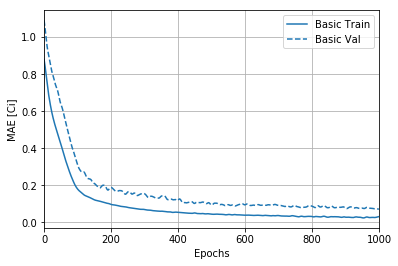

In [98]:
# The patience parameter is the amount of epochs to check for improvement
history = model_50_1_025.fit(normed_train_Am_df_025, normed_train_Ci_df_025,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history}, metric = "mae")
# plt.ylim([0, 1])
plt.ylabel('MAE [Ci]')
plt.show()

In [99]:
loss_50_1_025, mae_50_1_025, mse_50_1_025 = \
model_50_1_025.evaluate(normed_test_Am_df_025, normed_test_Ci_df_025, verbose=2)

10/10 - 0s - loss: 0.0024 - mae: 0.0385 - mse: 0.0024


In [100]:
# Scaled MAE
test_predictions_50_1_025 = model_50_1_025.predict(normed_test_Am_df_025)
error_50_1_025 = test_predictions_50_1_025 - normed_test_Ci_df_025
scaled_mae_50_1_025 = error_50_1_025.abs().mean()*train_Ci_stats_025['std']
print(scaled_mae_50_1_025)

C0    3.430675e-08
C1    3.009183e-08
dtype: float64


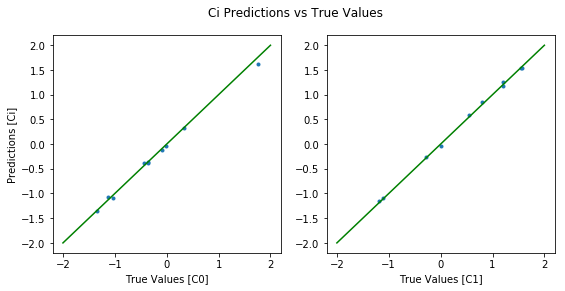

In [101]:
plot_predict(test_predictions_50_1_025, normed_test_Ci_df_025, lims=[-2,2])

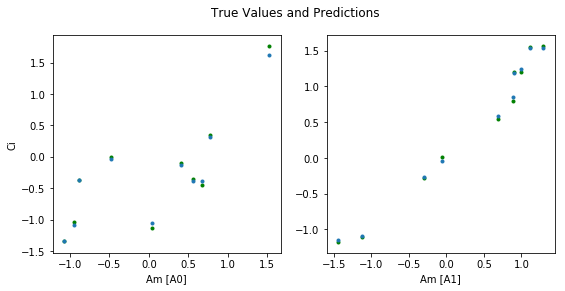

In [102]:
plot_true_and_pred(normed_test_Ci_df_025, test_predictions_50_1_025, normed_test_Am_df_025)

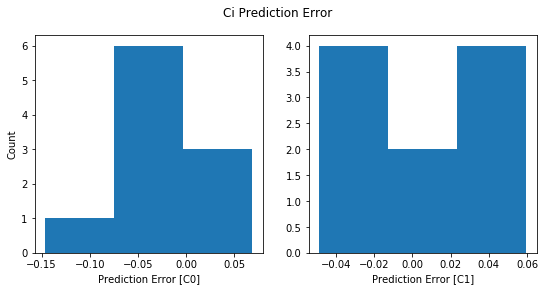

In [103]:
plot_error_hist(error_50_1_025,bins=3)

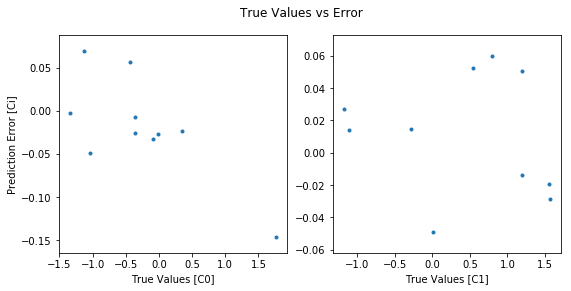

In [104]:
plot_true_v_error(normed_test_Ci_df_025, error_50_1_025)

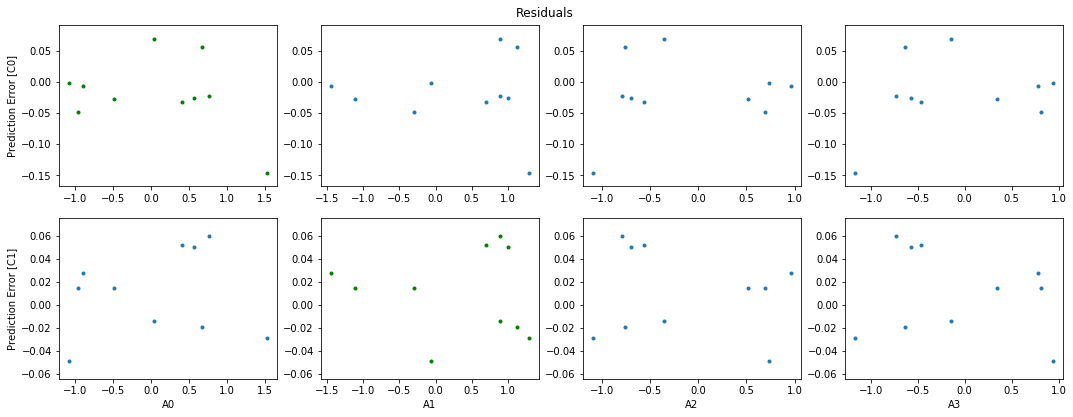

In [105]:
plot_residuals(normed_test_Am_df_025, error_50_1_025, green_list=[(0,0),(1,1),(2,2),(3,3)])

In [106]:
loss_50_1_025L, mae_50_1_025L, mse_50_1_025L = \
model_50_1_025.evaluate(large_normed_test_Am_df_025, large_normed_test_Ci_df_025, \
                        verbose=2)

1960/1960 - 0s - loss: 0.0047 - mae: 0.0497 - mse: 0.0047


In [107]:
# Scaled MAE
test_predictions_50_1_025L = model_50_1_025.predict(large_normed_test_Am_df_025)
error_50_1_025L = test_predictions_50_1_025L - large_normed_test_Ci_df_025
scaled_mae_50_1_025L = error_50_1_025L.abs().mean()*train_Ci_stats_025['std']
print(scaled_mae_50_1_025L)

C0    3.704469e-08
C1    4.742576e-08
dtype: float64


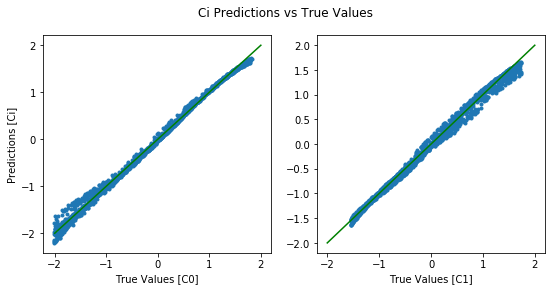

In [108]:
plot_predict(test_predictions_50_1_025L, large_normed_test_Ci_df_025, lims=[-2,2])

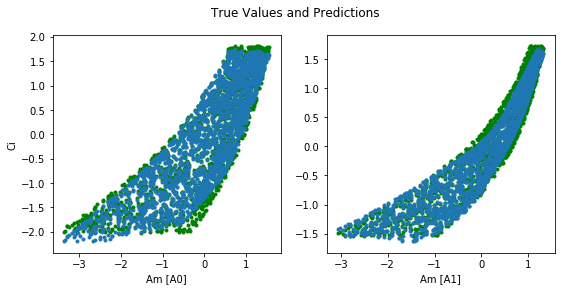

In [109]:
plot_true_and_pred(large_normed_test_Ci_df_025, test_predictions_50_1_025L, \
                   large_normed_test_Am_df_025)

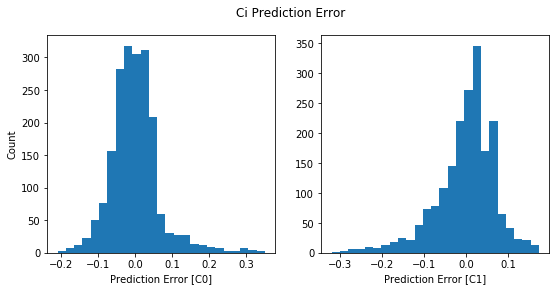

In [110]:
plot_error_hist(error_50_1_025L)

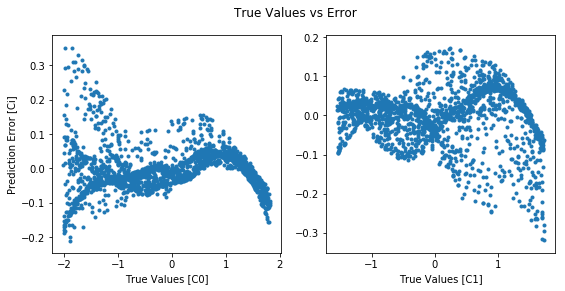

In [111]:
plot_true_v_error(large_normed_test_Ci_df_025, error_50_1_025L)

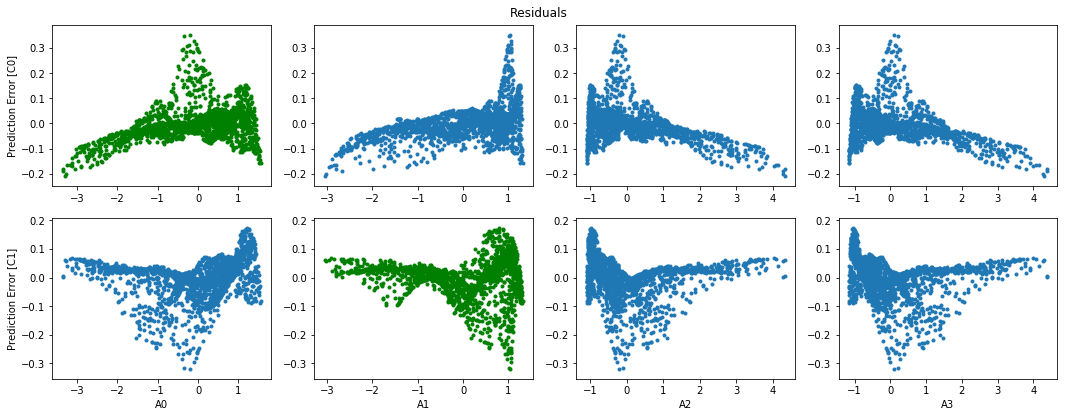

In [112]:
plot_residuals(large_normed_test_Am_df_025, error_50_1_025L, \
               green_list=[(0,0),(1,1),(2,2),(3,3)])

Now let's try 25 samples

In [113]:
train_Am_df_0125, train_Ci_df_0125, test_Am_df_0125, test_Ci_df_0125, large_test_Am_df_0125, \
        large_test_Ci_df_0125 = subset(Am_df, Ci_df, 0.0125, 0.8)

In [114]:
# Normalize data
train_Am_stats_0125 = get_stats(train_Am_df_0125)
normed_train_Am_df_0125 = Z_normalize_data(train_Am_df_0125, train_Am_stats_0125)
normed_test_Am_df_0125 = Z_normalize_data(test_Am_df_0125, train_Am_stats_0125)
large_normed_test_Am_df_0125 = Z_normalize_data(large_test_Am_df_0125, train_Am_stats_0125)
train_Ci_stats_0125 = get_stats(train_Ci_df_0125)
normed_train_Ci_df_0125 = Z_normalize_data(train_Ci_df_0125, train_Ci_stats_0125)
normed_test_Ci_df_0125 = Z_normalize_data(test_Ci_df_0125, train_Ci_stats_0125)
large_normed_test_Ci_df_0125 = Z_normalize_data(large_test_Ci_df_0125, train_Ci_stats_0125)

In [115]:
model_50_1_0125 = build_model(50,1,"relu")


Epoch: 0, loss:0.9752,  mae:0.8669,  mse:0.9752,  val_loss:0.6213,  val_mae:0.6421,  val_mse:0.6213,  
....................................................................................................
Epoch: 100, loss:0.0394,  mae:0.1498,  mse:0.0394,  val_loss:0.1426,  val_mae:0.3215,  val_mse:0.1426,  
....................................................................................................
Epoch: 200, loss:0.0086,  mae:0.0660,  mse:0.0086,  val_loss:0.0759,  val_mae:0.2039,  val_mse:0.0759,  
....................................................................................................
Epoch: 300, loss:0.0049,  mae:0.0493,  mse:0.0049,  val_loss:0.0689,  val_mae:0.1970,  val_mse:0.0689,  
....................................................................................................
Epoch: 400, loss:0.0030,  mae:0.0389,  mse:0.0030,  val_loss:0.0603,  val_mae:0.1833,  val_mse:0.0603,  
........................................................................

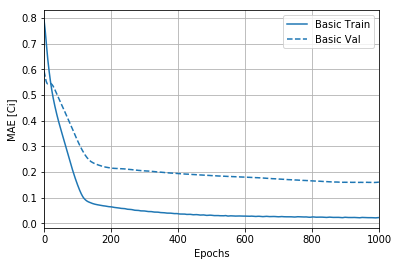

In [116]:
history = model_50_1_0125.fit(normed_train_Am_df_0125, normed_train_Ci_df_0125,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [Ci]')
plt.show()

In [117]:
loss_50_1_0125, mae_50_1_0125, mse_50_1_0125 = \
model_50_1_0125.evaluate(normed_test_Am_df_0125, normed_test_Ci_df_0125, verbose=2)

5/5 - 0s - loss: 0.0016 - mae: 0.0302 - mse: 0.0016


In [118]:
# Scaled MAE
test_predictions_50_1_0125 = model_50_1_0125.predict(normed_test_Am_df_0125)
error_50_1_0125 = test_predictions_50_1_0125 - normed_test_Ci_df_0125
scaled_mae_50_1_0125 = error_50_1_0125.abs().mean()*train_Ci_stats_0125['std']
print(scaled_mae_50_1_0125)

C0    2.491604e-08
C1    2.989303e-08
dtype: float64


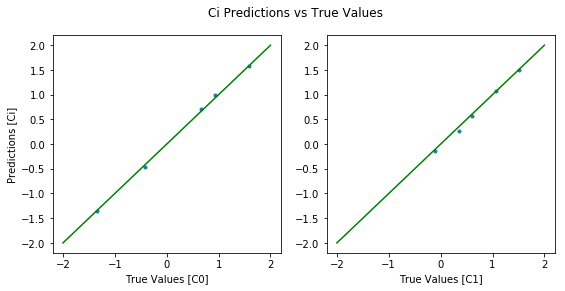

In [119]:
plot_predict(test_predictions_50_1_0125, normed_test_Ci_df_0125, lims=[-2,2])

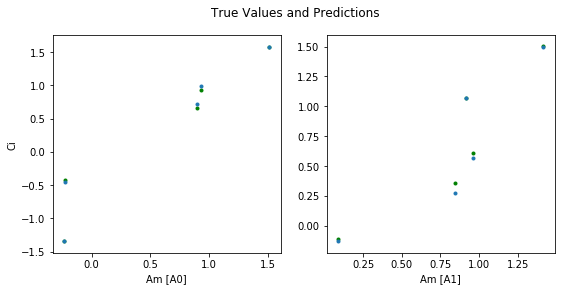

In [120]:
plot_true_and_pred(normed_test_Ci_df_0125, test_predictions_50_1_0125, normed_test_Am_df_0125)

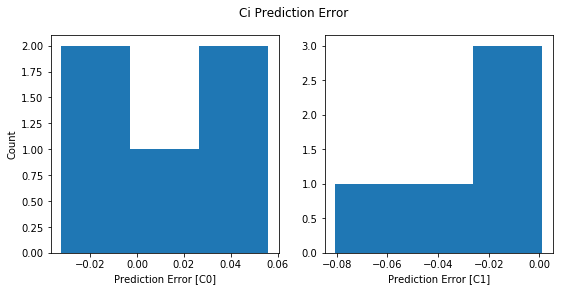

In [121]:
plot_error_hist(error_50_1_0125,bins=3)

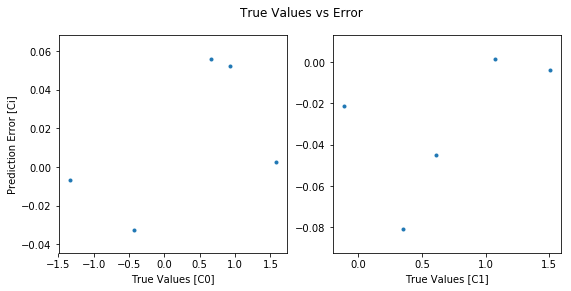

In [122]:
plot_true_v_error(normed_test_Ci_df_0125, error_50_1_0125)

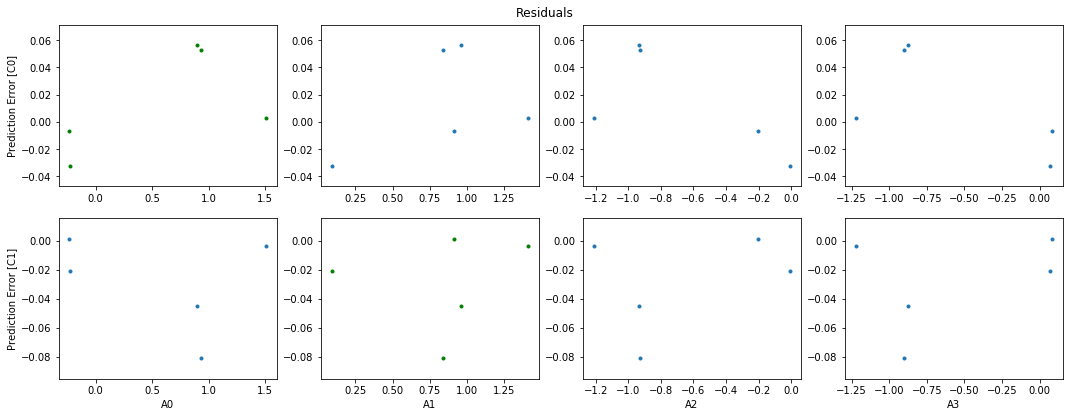

In [123]:
plot_residuals(normed_test_Am_df_0125, error_50_1_0125, green_list=[(0,0),(1,1),(2,2),(3,3)])


In [124]:
loss_50_1_0125L, mae_50_1_0125L, mse_50_1_0125L = \
model_50_1_0125.evaluate(large_normed_test_Am_df_0125, large_normed_test_Ci_df_0125, \
                        verbose=2)

1980/1980 - 0s - loss: 0.0103 - mae: 0.0723 - mse: 0.0103


In [125]:
# Scaled MAE
test_predictions_50_1_0125L = model_50_1_0125.predict(large_normed_test_Am_df_0125)
error_50_1_0125L = test_predictions_50_1_0125L - large_normed_test_Ci_df_0125
scaled_mae_50_1_0125L = error_50_1_0125L.abs().mean()*train_Ci_stats_0125['std']
print(scaled_mae_50_1_0125L)

C0    6.770323e-08
C1    6.193310e-08
dtype: float64


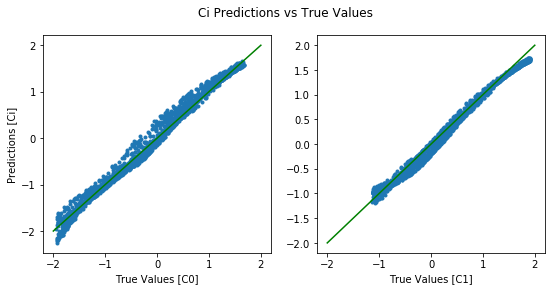

In [126]:
plot_predict(test_predictions_50_1_0125L, large_normed_test_Ci_df_0125, lims=[-2,2])

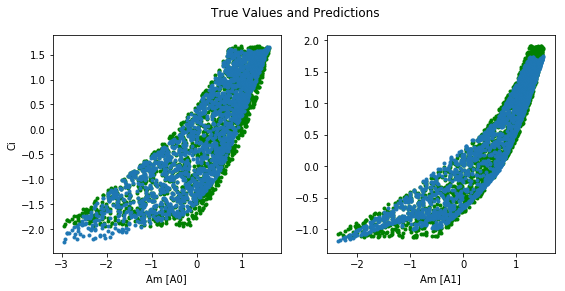

In [127]:
plot_true_and_pred(large_normed_test_Ci_df_0125, test_predictions_50_1_0125L, \
                   large_normed_test_Am_df_0125)

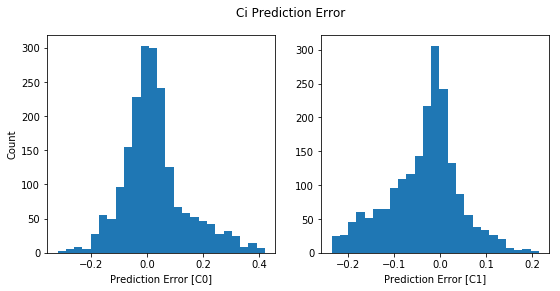

In [128]:
plot_error_hist(error_50_1_0125L)

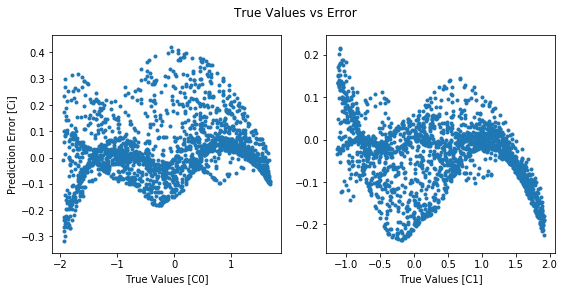

In [129]:
plot_true_v_error(large_normed_test_Ci_df_0125, error_50_1_0125L)

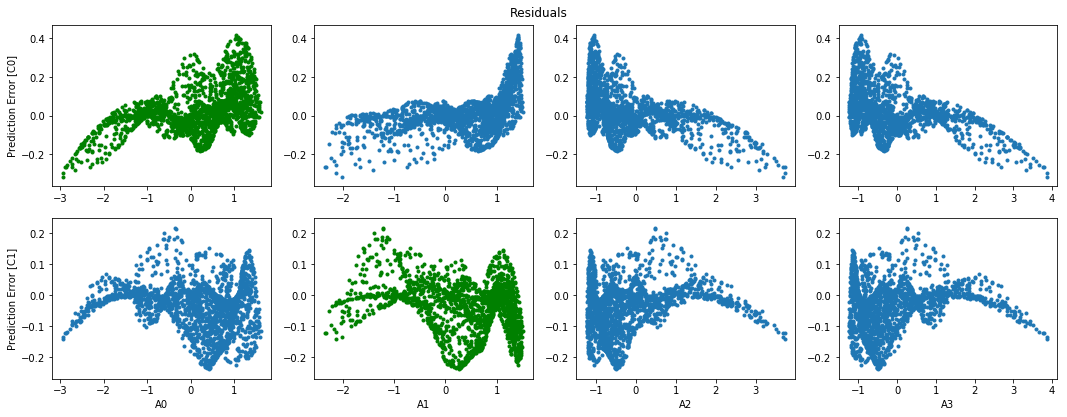

In [130]:
plot_residuals(large_normed_test_Am_df_0125, error_50_1_0125L, \
               green_list=[(0,0),(1,1),(2,2),(3,3)])

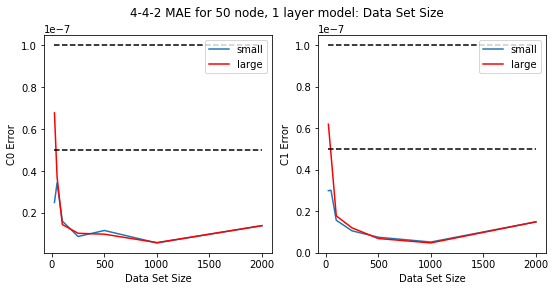

In [131]:
fig, ax = plt.subplots(1,2,figsize=(9,4))
fig.suptitle('4-4-2 MAE for 50 node, 1 layer model: Data Set Size')
for i in range(2):
    ax[i].plot([2000,1000,500,250,100, 50, 25],\
             [scaled_mae_50_1[i], scaled_mae_50_1_50[i], scaled_mae_50_1_25[i], \
              scaled_mae_50_1_125[i], scaled_mae_50_1_05[i], scaled_mae_50_1_025[i], scaled_mae_50_1_0125[i]], \
              label='small')
    ax[i].plot([2000,1000,500,250,100, 50, 25],\
             [scaled_mae_50_1[i], scaled_mae_50_1_50L[i], scaled_mae_50_1_25L[i], \
              scaled_mae_50_1_125L[i], scaled_mae_50_1_05L[i], scaled_mae_50_1_025L[i], \
              scaled_mae_50_1_0125L[i]],\
             'r', label='large')
#     ax[i].scatter([2000],[scaled_mae_50_1_mm[i]], marker='.', c='g', label='Min-Max')
    ax[i].plot([25,2000],[1e-7,1e-7],'k--')
    ax[i].plot([25,2000],[5e-8,5e-8],'k--')
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel('Data Set Size')
    ax[i].set_ylabel('C{} Error'.format(i))
#     ax[i].set_ylim(0,1.5e-7)

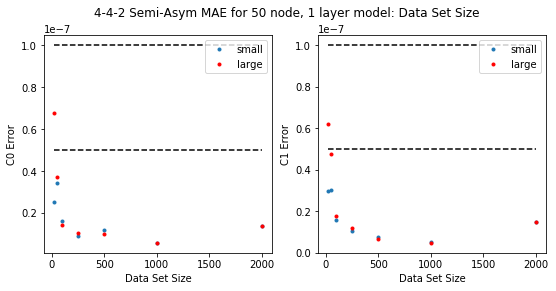

In [202]:
fig, ax = plt.subplots(1,2,figsize=(9,4))
fig.suptitle('4-4-2 Semi-Asym MAE for 50 node, 1 layer model: Data Set Size')
for i in range(2):
    ax[i].plot([2000,1000,500,250,100, 50, 25],\
             [scaled_mae_50_1[i], scaled_mae_50_1_50[i], scaled_mae_50_1_25[i], \
              scaled_mae_50_1_125[i], scaled_mae_50_1_05[i], scaled_mae_50_1_025[i], scaled_mae_50_1_0125[i]], \
              '.', label='small')
    ax[i].plot([2000,1000,500,250,100, 50, 25],\
             [scaled_mae_50_1[i], scaled_mae_50_1_50L[i], scaled_mae_50_1_25L[i], \
              scaled_mae_50_1_125L[i], scaled_mae_50_1_05L[i], scaled_mae_50_1_025L[i], \
              scaled_mae_50_1_0125L[i]],\
             'r.', label='large')
#     ax[i].scatter([2000],[scaled_mae_50_1_mm[i]], marker='.', c='g', label='Min-Max')
    ax[i].plot([25,2000],[1e-7,1e-7],'k--')
    ax[i].plot([25,2000],[5e-8,5e-8],'k--')
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel('Data Set Size')
    ax[i].set_ylabel('C{} Error'.format(i))
#     ax[i].set_ylim(0,1.5e-7)

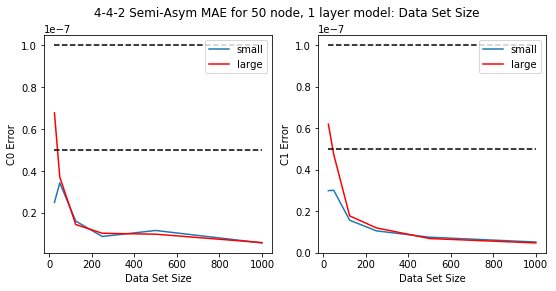

In [201]:
fig, ax = plt.subplots(1,2,figsize=(9,4))
fig.suptitle('4-4-2 Semi-Asym MAE for 50 node, 1 layer model: Data Set Size')
for i in range(2):
    ax[i].plot([1000,500,250,125, 50, 25],\
             [scaled_mae_50_1_50[i], scaled_mae_50_1_25[i], \
              scaled_mae_50_1_125[i], scaled_mae_50_1_05[i], scaled_mae_50_1_025[i], scaled_mae_50_1_0125[i]], \
              label='small')
    ax[i].plot([1000,500,250,125, 50, 25],\
             [scaled_mae_50_1_50L[i], scaled_mae_50_1_25L[i], \
              scaled_mae_50_1_125L[i], scaled_mae_50_1_05L[i], scaled_mae_50_1_025L[i], \
              scaled_mae_50_1_0125L[i]],\
             'r', label='large')
#     ax[i].scatter([2000],[scaled_mae_50_1_mm[i]], marker='.', c='g', label='Min-Max')
    ax[i].plot([25,1000],[1e-7,1e-7],'k--')
    ax[i].plot([25,1000],[5e-8,5e-8],'k--')
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel('Data Set Size')
    ax[i].set_ylabel('C{} Error'.format(i))
#     ax[i].set_ylim(0,1.5e-7)

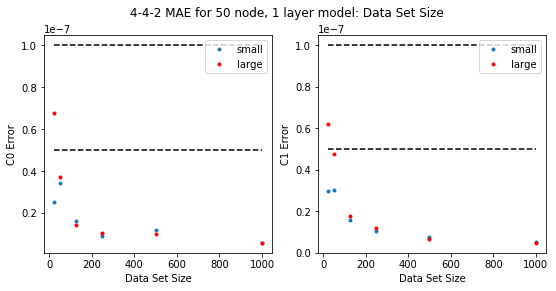

In [134]:
fig, ax = plt.subplots(1,2,figsize=(9,4))
fig.suptitle('4-4-2 MAE for 50 node, 1 layer model: Data Set Size')
for i in range(2):
    ax[i].plot([1000,500,250,125, 50, 25],\
             [scaled_mae_50_1_50[i], scaled_mae_50_1_25[i], \
              scaled_mae_50_1_125[i], scaled_mae_50_1_05[i], scaled_mae_50_1_025[i], scaled_mae_50_1_0125[i]], \
              '.', label='small')
    ax[i].plot([1000,500,250,125, 50, 25],\
             [scaled_mae_50_1_50L[i], scaled_mae_50_1_25L[i], \
              scaled_mae_50_1_125L[i], scaled_mae_50_1_05L[i], scaled_mae_50_1_025L[i], \
              scaled_mae_50_1_0125L[i]],\
             'r.', label='large')
#     ax[i].scatter([2000],[scaled_mae_50_1_mm[i]], marker='.', c='g', label='Min-Max')
    ax[i].plot([25,1000],[1e-7,1e-7],'k--')
    ax[i].plot([25,1000],[5e-8,5e-8],'k--')
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel('Data Set Size')
    ax[i].set_ylabel('C{} Error'.format(i))
#     ax[i].set_ylim(0,1.5e-7)

Now let's try a few different model sizes

First let's try a 20 node, 1 layer model on 1000 samples, so we can compare with the 2-2-2 system

In [135]:
model_20_1_50 = build_model(20,1,"relu")


Epoch: 0, loss:0.9362,  mae:0.8166,  mse:0.9362,  val_loss:0.7536,  val_mae:0.7378,  val_mse:0.7536,  
....................................................................................................
Epoch: 100, loss:0.0017,  mae:0.0323,  mse:0.0017,  val_loss:0.0017,  val_mae:0.0331,  val_mse:0.0017,  
....................................................................................................
Epoch: 200, loss:0.0011,  mae:0.0260,  mse:0.0011,  val_loss:0.0011,  val_mae:0.0265,  val_mse:0.0011,  
....................................................................................................
Epoch: 300, loss:0.0010,  mae:0.0246,  mse:0.0010,  val_loss:0.0011,  val_mae:0.0262,  val_mse:0.0011,  
....................................................................................................
Epoch: 400, loss:0.0009,  mae:0.0233,  mse:0.0009,  val_loss:0.0012,  val_mae:0.0265,  val_mse:0.0012,  
........................................................................

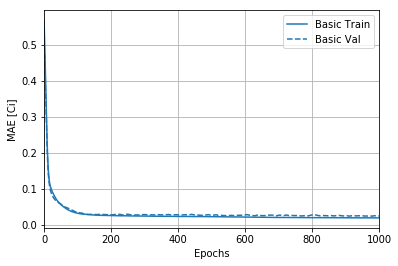

In [136]:
history = model_20_1_50.fit(normed_train_Am_df_50, normed_train_Ci_df_50,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [Ci]')
plt.show()

In [137]:
loss_20_1_50, mae_20_1_50, mse_20_1_50 = \
model_20_1_50.evaluate(normed_test_Am_df_50, normed_test_Ci_df_50, verbose=2)

200/200 - 0s - loss: 0.0013 - mae: 0.0280 - mse: 0.0013


In [138]:
# Scaled MAE
test_predictions_20_1_50 = model_20_1_50.predict(normed_test_Am_df_50)
error_20_1_50 = test_predictions_20_1_50 - normed_test_Ci_df_50
scaled_mae_20_1_50 = error_20_1_50.abs().mean()*train_Ci_stats_50['std']
print(scaled_mae_20_1_50)

C0    1.961474e-08
C1    2.881975e-08
dtype: float64


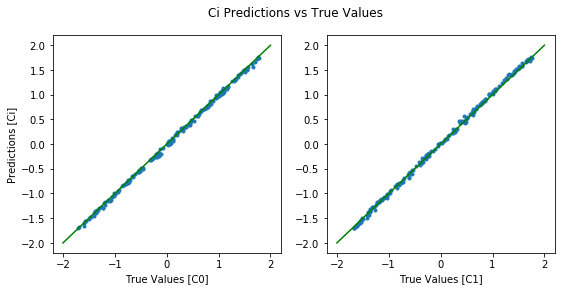

In [139]:
plot_predict(test_predictions_20_1_50, normed_test_Ci_df_50, lims=[-2,2])

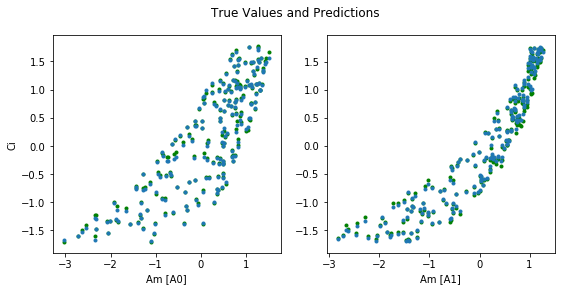

In [140]:
plot_true_and_pred(normed_test_Ci_df_50, test_predictions_20_1_50, normed_test_Am_df_50)

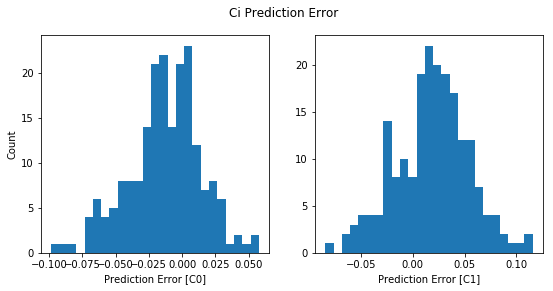

In [141]:
plot_error_hist(error_20_1_50)

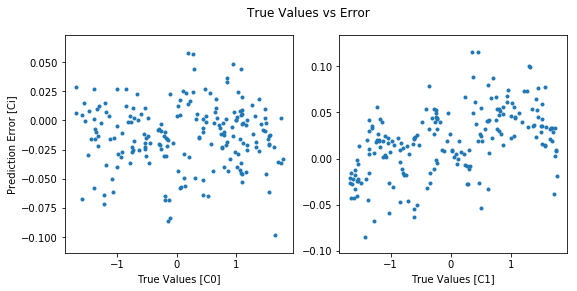

In [142]:
plot_true_v_error(normed_test_Ci_df_50, error_20_1_50)

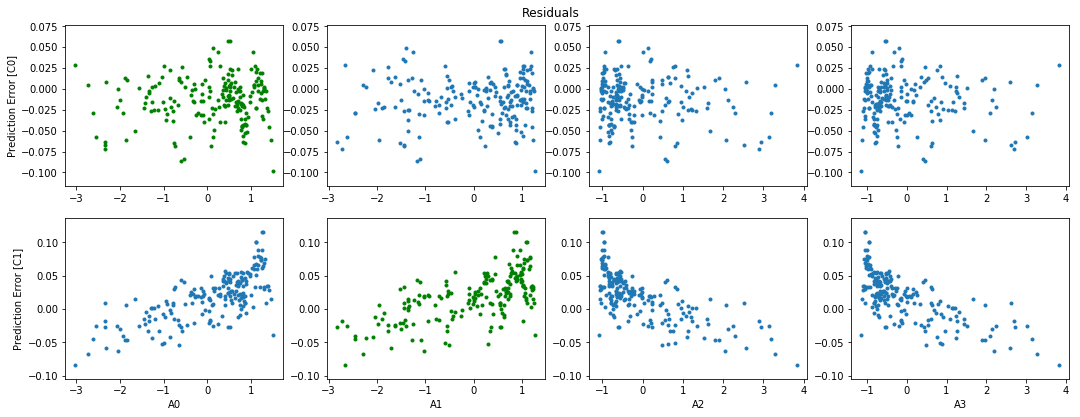

In [143]:
plot_residuals(normed_test_Am_df_50, error_20_1_50, green_list=[(0,0),(1,1),(2,2),(3,3)])

In [144]:
loss_20_1_50L, mae_20_1_50L, mse_20_1_50L = \
model_20_1_50.evaluate(large_normed_test_Am_df_50, large_normed_test_Ci_df_50, \
                        verbose=2)

1200/1200 - 0s - loss: 0.0012 - mae: 0.0274 - mse: 0.0012


In [145]:
# Scaled MAE
test_predictions_20_1_50L = model_20_1_50.predict(large_normed_test_Am_df_50)
error_20_1_50L = test_predictions_20_1_50L - large_normed_test_Ci_df_50
scaled_mae_20_1_50L = error_20_1_50L.abs().mean()*train_Ci_stats_50['std']
print(scaled_mae_20_1_50L)

C0    1.832910e-08
C1    2.895862e-08
dtype: float64


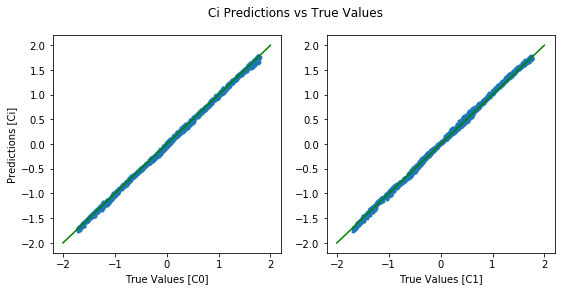

In [146]:
plot_predict(test_predictions_20_1_50L, large_normed_test_Ci_df_50, lims=[-2,2])

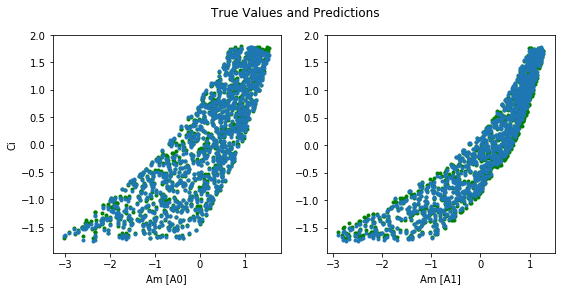

In [147]:
plot_true_and_pred(large_normed_test_Ci_df_50, test_predictions_20_1_50L, \
                   large_normed_test_Am_df_50)

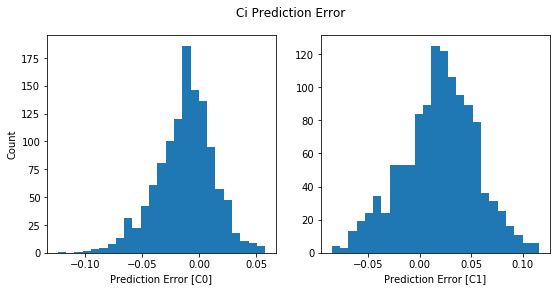

In [148]:
plot_error_hist(error_20_1_50L)

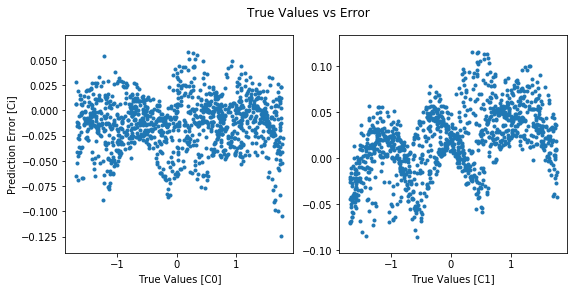

In [149]:
plot_true_v_error(large_normed_test_Ci_df_50, error_20_1_50L)

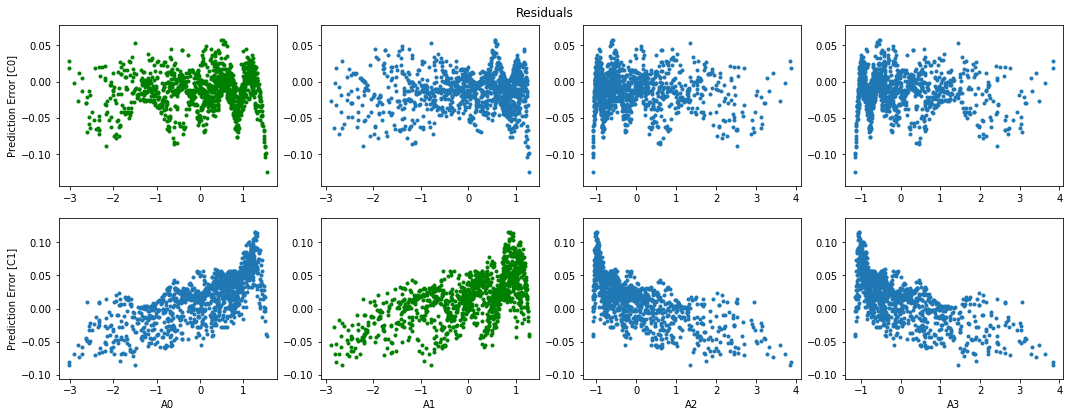

In [150]:
plot_residuals(large_normed_test_Am_df_50, error_20_1_50L, \
               green_list=[(0,0),(1,1),(2,2),(3,3)])

Now let's try a 10 node, 1 layer model

In [151]:
model_10_1_50 = build_model(10,1,"relu")


Epoch: 0, loss:0.8039,  mae:0.7214,  mse:0.8039,  val_loss:0.6284,  val_mae:0.6258,  val_mse:0.6284,  
....................................................................................................
Epoch: 100, loss:0.0036,  mae:0.0477,  mse:0.0036,  val_loss:0.0041,  val_mae:0.0516,  val_mse:0.0041,  
....................................................................................................
Epoch: 200, loss:0.0015,  mae:0.0304,  mse:0.0015,  val_loss:0.0015,  val_mae:0.0296,  val_mse:0.0015,  
....................................................................................................
Epoch: 300, loss:0.0010,  mae:0.0254,  mse:0.0010,  val_loss:0.0010,  val_mae:0.0250,  val_mse:0.0010,  
....................................................................................................
Epoch: 400, loss:0.0009,  mae:0.0234,  mse:0.0009,  val_loss:0.0009,  val_mae:0.0229,  val_mse:0.0009,  
........................................................................

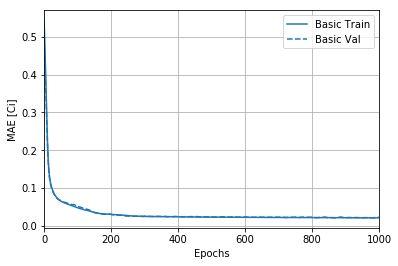

In [152]:
history = model_10_1_50.fit(normed_train_Am_df_50, normed_train_Ci_df_50,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [Ci]')
plt.show()

In [153]:
loss_10_1_50, mae_10_1_50, mse_10_1_50 = \
model_10_1_50.evaluate(normed_test_Am_df_50, normed_test_Ci_df_50, verbose=2)

200/200 - 0s - loss: 0.0012 - mae: 0.0274 - mse: 0.0012


In [154]:
# Scaled MAE
test_predictions_10_1_50 = model_10_1_50.predict(normed_test_Am_df_50)
error_10_1_50 = test_predictions_10_1_50 - normed_test_Ci_df_50
scaled_mae_10_1_50 = error_10_1_50.abs().mean()*train_Ci_stats_50['std']
print(scaled_mae_10_1_50)

C0    2.354072e-08
C1    2.375490e-08
dtype: float64


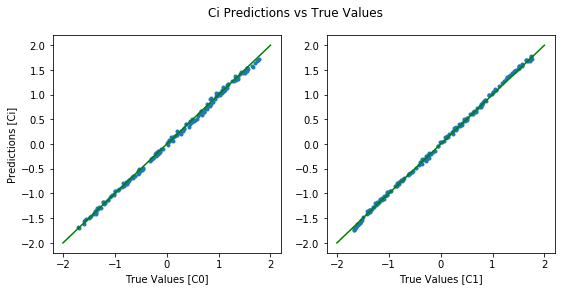

In [155]:
plot_predict(test_predictions_10_1_50, normed_test_Ci_df_50, lims=[-2,2])

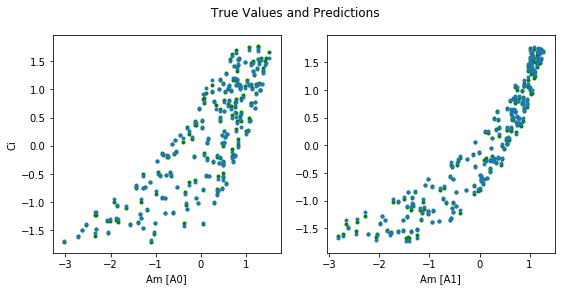

In [156]:
plot_true_and_pred(normed_test_Ci_df_50, test_predictions_10_1_50, normed_test_Am_df_50)

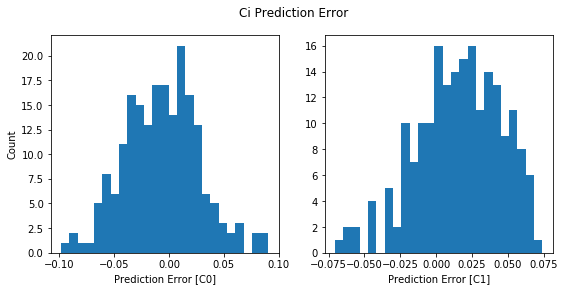

In [157]:
plot_error_hist(error_10_1_50)

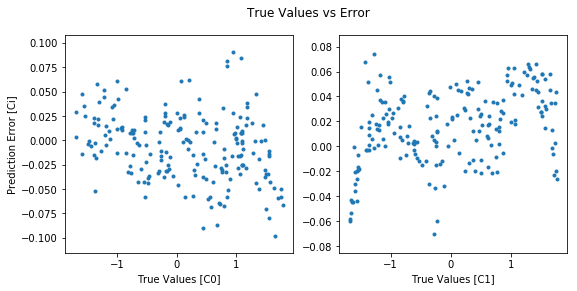

In [158]:
plot_true_v_error(normed_test_Ci_df_50, error_10_1_50)

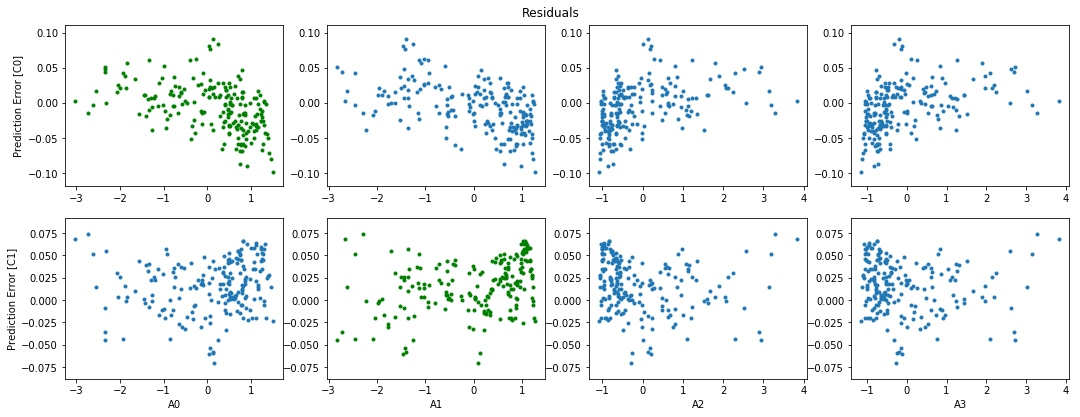

In [159]:
plot_residuals(normed_test_Am_df_50, error_10_1_50, green_list=[(0,0),(1,1),(2,2),(3,3)])

In [160]:
loss_10_1_50L, mae_10_1_50L, mse_10_1_50L = \
model_10_1_50.evaluate(large_normed_test_Am_df_50, large_normed_test_Ci_df_50, \
                        verbose=2)

1200/1200 - 0s - loss: 0.0011 - mae: 0.0268 - mse: 0.0011


In [161]:
# Scaled MAE
test_predictions_10_1_50L = model_10_1_50.predict(large_normed_test_Am_df_50)
error_10_1_50L = test_predictions_10_1_50L - large_normed_test_Ci_df_50
scaled_mae_10_1_50L = error_10_1_50L.abs().mean()*train_Ci_stats_50['std']
print(scaled_mae_10_1_50L)

C0    2.320878e-08
C1    2.307515e-08
dtype: float64


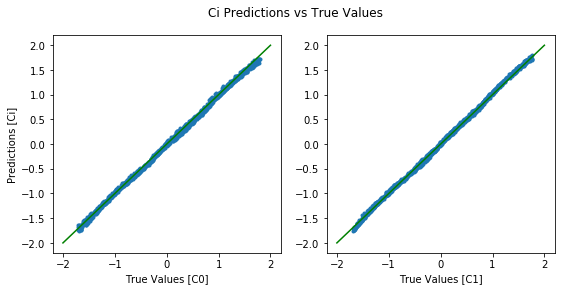

In [162]:
plot_predict(test_predictions_10_1_50L, large_normed_test_Ci_df_50, lims=[-2,2])

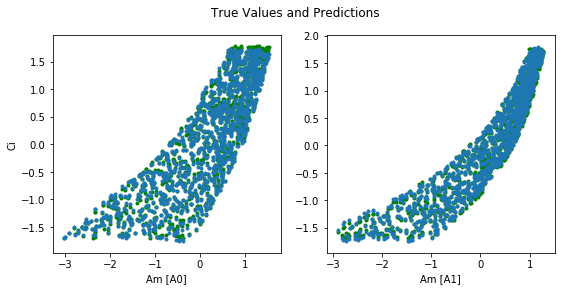

In [163]:
plot_true_and_pred(large_normed_test_Ci_df_50, test_predictions_10_1_50L, \
                   large_normed_test_Am_df_50)

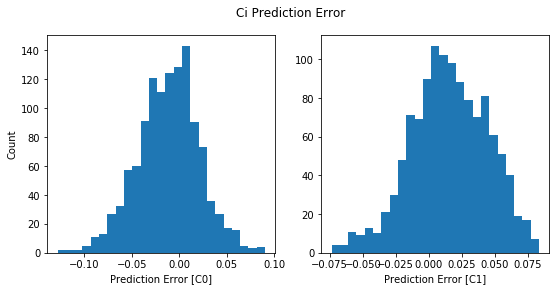

In [164]:
plot_error_hist(error_10_1_50L)

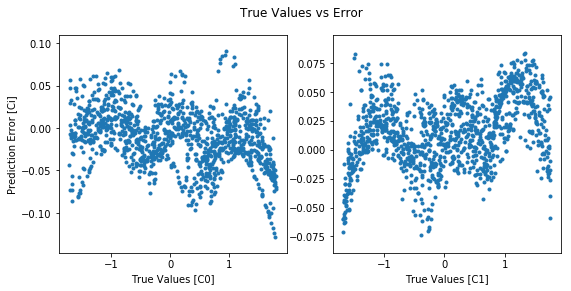

In [165]:
plot_true_v_error(large_normed_test_Ci_df_50, error_10_1_50L)

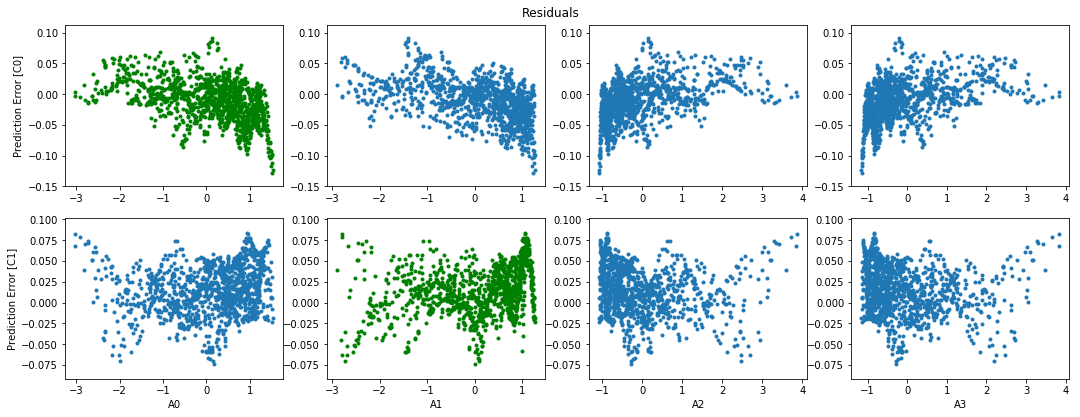

In [166]:
plot_residuals(large_normed_test_Am_df_50, error_10_1_50L, \
               green_list=[(0,0),(1,1),(2,2),(3,3)])

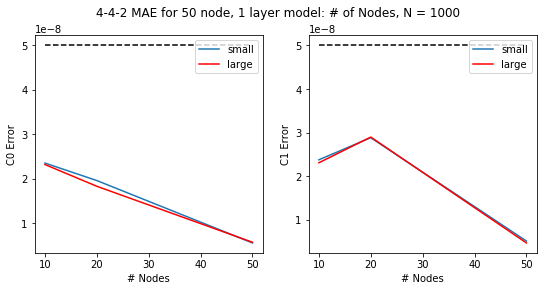

In [167]:
fig, ax = plt.subplots(1,2,figsize=(9,4))
fig.suptitle('4-4-2 MAE for 50 node, 1 layer model: # of Nodes, N = 1000')
for i in range(2):
    ax[i].plot([50,20,10],\
             [scaled_mae_50_1_50[i], scaled_mae_20_1_50[i], scaled_mae_10_1_50[i]], \
              label='small')
    ax[i].plot([50,20,10],\
             [scaled_mae_50_1_50L[i], scaled_mae_20_1_50L[i], scaled_mae_10_1_50L[i]],\
             'r', label='large')
#     ax[i].scatter([2000],[scaled_mae_50_1_mm[i]], marker='.', c='g', label='Min-Max')
#     ax[i].plot([10,50],[1e-7,1e-7],'k--')
    ax[i].plot([10,50],[5e-8,5e-8],'k--')
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel('# Nodes')
    ax[i].set_ylabel('C{} Error'.format(i))
#     ax[i].set_ylim(0,1.5e-7)

There's not much of a difference. Let's try using less data.

In [168]:
model_20_1_25 = build_model(20,1,"relu")


Epoch: 0, loss:0.7832,  mae:0.7534,  mse:0.7832,  val_loss:0.7767,  val_mae:0.7367,  val_mse:0.7767,  
....................................................................................................
Epoch: 100, loss:0.0042,  mae:0.0503,  mse:0.0042,  val_loss:0.0068,  val_mae:0.0632,  val_mse:0.0068,  
....................................................................................................
Epoch: 200, loss:0.0014,  mae:0.0290,  mse:0.0014,  val_loss:0.0032,  val_mae:0.0461,  val_mse:0.0032,  
....................................................................................................
Epoch: 300, loss:0.0010,  mae:0.0240,  mse:0.0010,  val_loss:0.0018,  val_mae:0.0331,  val_mse:0.0018,  
....................................................................................................
Epoch: 400, loss:0.0008,  mae:0.0209,  mse:0.0008,  val_loss:0.0013,  val_mae:0.0285,  val_mse:0.0013,  
........................................................................

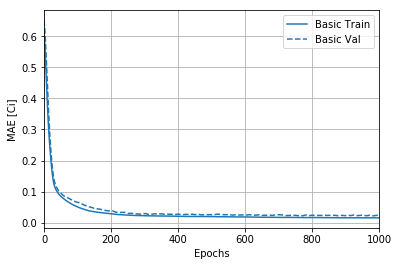

In [169]:
history = model_20_1_25.fit(normed_train_Am_df_25, normed_train_Ci_df_25,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [Ci]')
plt.show()

In [170]:
loss_20_1_25, mae_20_1_25, mse_20_1_25 = \
model_20_1_25.evaluate(normed_test_Am_df_25, normed_test_Ci_df_25, verbose=2)

100/100 - 0s - loss: 0.0011 - mae: 0.0257 - mse: 0.0011


In [171]:
# Scaled MAE
test_predictions_20_1_25 = model_20_1_25.predict(normed_test_Am_df_25)
error_20_1_25 = test_predictions_20_1_25 - normed_test_Ci_df_25
scaled_mae_20_1_25 = error_20_1_25.abs().mean()*train_Ci_stats_25['std']
print(scaled_mae_20_1_25)

C0    2.231386e-08
C1    2.244891e-08
dtype: float64


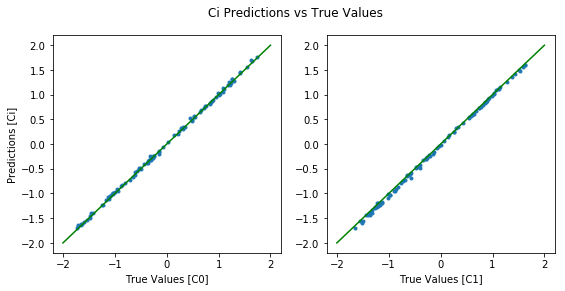

In [172]:
plot_predict(test_predictions_20_1_25, normed_test_Ci_df_25, lims=[-2,2])

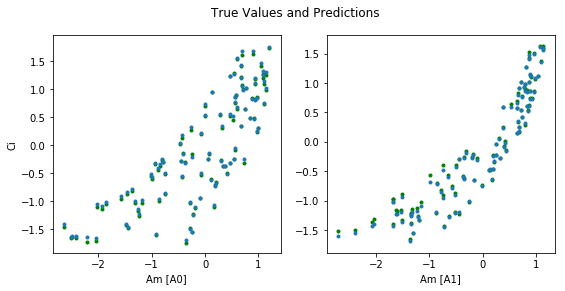

In [173]:
plot_true_and_pred(normed_test_Ci_df_25, test_predictions_20_1_25, normed_test_Am_df_25)

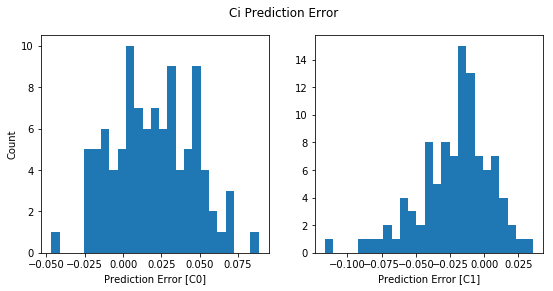

In [174]:
plot_error_hist(error_20_1_25)

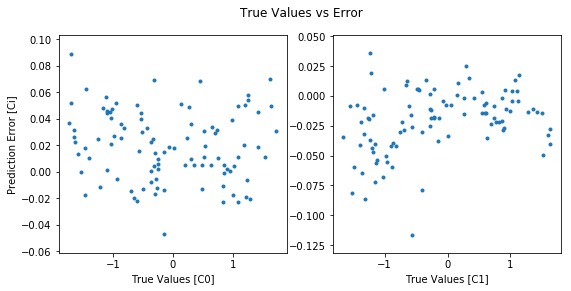

In [175]:
plot_true_v_error(normed_test_Ci_df_25, error_20_1_25)

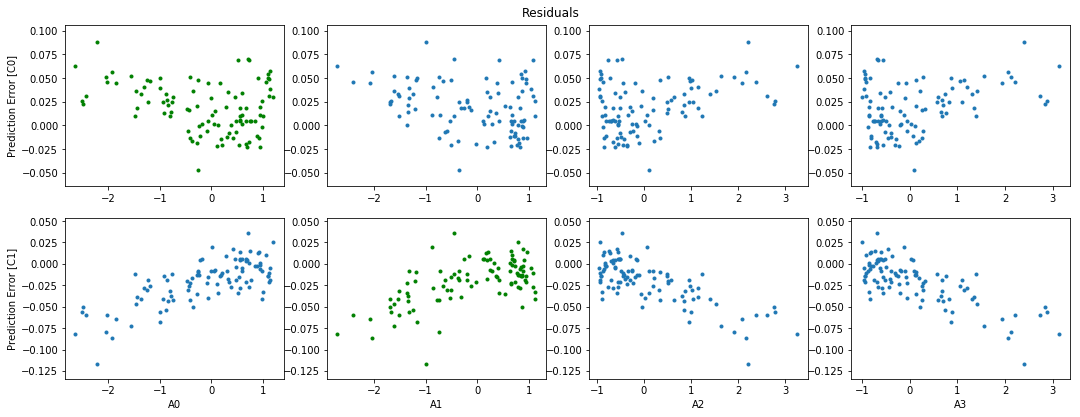

In [176]:
plot_residuals(normed_test_Am_df_25, error_20_1_25, green_list=[(0,0),(1,1),(2,2),(3,3)])

In [177]:
loss_20_1_25L, mae_20_1_25L, mse_20_1_25L = \
model_20_1_25.evaluate(large_normed_test_Am_df_25, large_normed_test_Ci_df_25, \
                        verbose=2)

1600/1600 - 0s - loss: 0.0011 - mae: 0.0253 - mse: 0.0011


In [178]:
# Scaled MAE
test_predictions_20_1_25L = model_20_1_25.predict(large_normed_test_Am_df_25)
error_20_1_25L = test_predictions_20_1_25L - large_normed_test_Ci_df_25
scaled_mae_20_1_25L = error_20_1_25L.abs().mean()*train_Ci_stats_25['std']
print(scaled_mae_20_1_25L)

C0    2.263621e-08
C1    2.149677e-08
dtype: float64


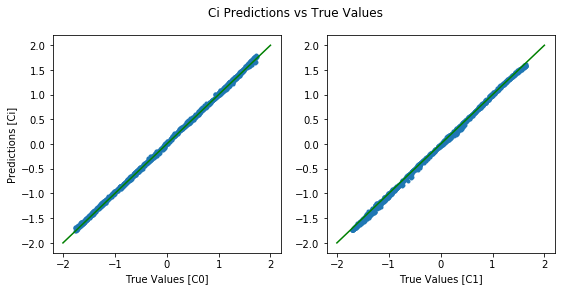

In [179]:
plot_predict(test_predictions_20_1_25L, large_normed_test_Ci_df_25, lims=[-2,2])

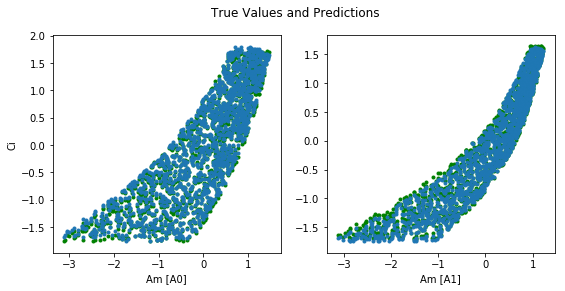

In [180]:
plot_true_and_pred(large_normed_test_Ci_df_25, test_predictions_20_1_25L, \
                   large_normed_test_Am_df_25)

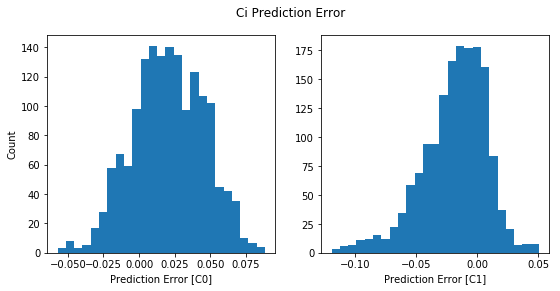

In [181]:
plot_error_hist(error_20_1_25L)

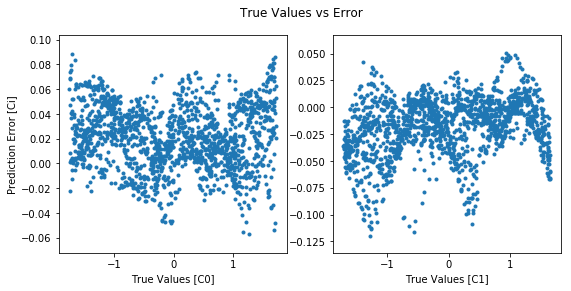

In [182]:
plot_true_v_error(large_normed_test_Ci_df_25, error_20_1_25L)

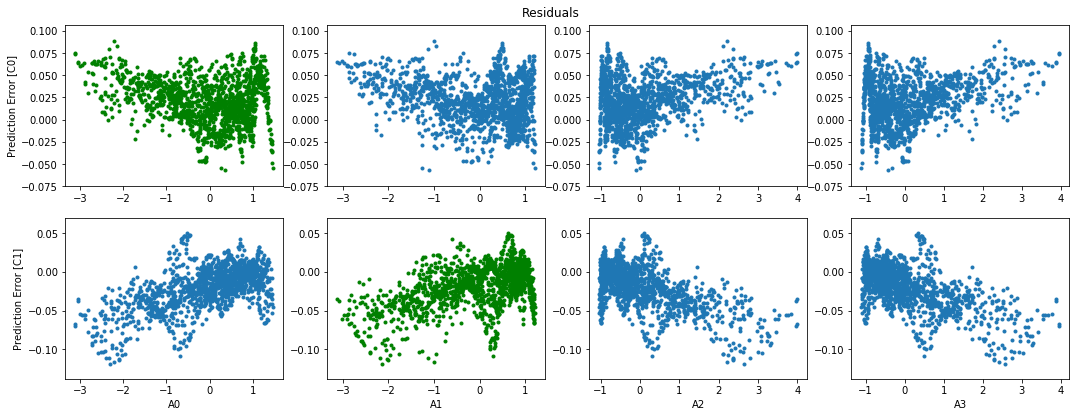

In [183]:
plot_residuals(large_normed_test_Am_df_25, error_20_1_25L, \
               green_list=[(0,0),(1,1),(2,2),(3,3)])

In [184]:
model_10_1_25 = build_model(10,1,"relu")


Epoch: 0, loss:0.6992,  mae:0.6835,  mse:0.6992,  val_loss:0.8132,  val_mae:0.7465,  val_mse:0.8132,  
....................................................................................................
Epoch: 100, loss:0.0053,  mae:0.0574,  mse:0.0053,  val_loss:0.0067,  val_mae:0.0630,  val_mse:0.0067,  
....................................................................................................
Epoch: 200, loss:0.0024,  mae:0.0377,  mse:0.0024,  val_loss:0.0039,  val_mae:0.0450,  val_mse:0.0039,  
....................................................................................................
Epoch: 300, loss:0.0020,  mae:0.0349,  mse:0.0020,  val_loss:0.0022,  val_mae:0.0365,  val_mse:0.0022,  
....................................................................................................
Epoch: 400, loss:0.0018,  mae:0.0329,  mse:0.0018,  val_loss:0.0020,  val_mae:0.0340,  val_mse:0.0020,  
........................................................................

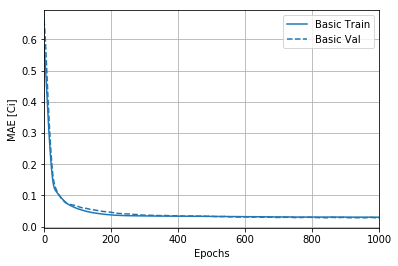

In [185]:
history = model_10_1_25.fit(normed_train_Am_df_25, normed_train_Ci_df_25,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])
plotter.plot({'Basic': history}, metric = "mae")
plt.ylabel('MAE [Ci]')
plt.show()

In [186]:
loss_10_1_25, mae_10_1_25, mse_10_1_25 = \
model_10_1_25.evaluate(normed_test_Am_df_25, normed_test_Ci_df_25, verbose=2)

100/100 - 0s - loss: 0.0012 - mae: 0.0270 - mse: 0.0012


In [187]:
# Scaled MAE
test_predictions_10_1_25 = model_10_1_25.predict(normed_test_Am_df_25)
error_10_1_25 = test_predictions_10_1_25 - normed_test_Ci_df_25
scaled_mae_10_1_25 = error_10_1_25.abs().mean()*train_Ci_stats_25['std']
print(scaled_mae_10_1_25)

C0    2.474004e-08
C1    2.237066e-08
dtype: float64


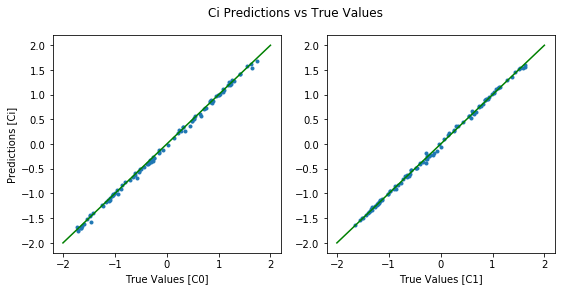

In [188]:
plot_predict(test_predictions_10_1_25, normed_test_Ci_df_25, lims=[-2,2])

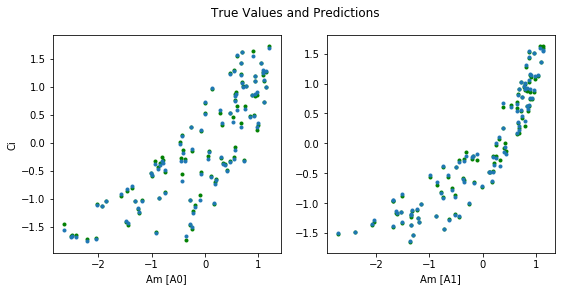

In [189]:
plot_true_and_pred(normed_test_Ci_df_25, test_predictions_10_1_25, normed_test_Am_df_25)

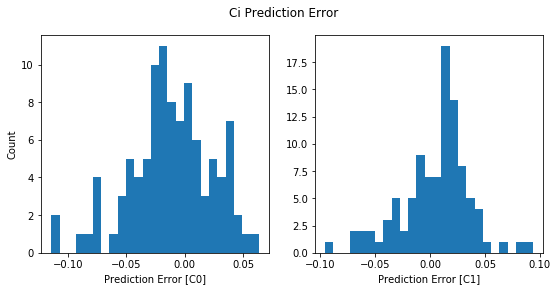

In [190]:
plot_error_hist(error_10_1_25)

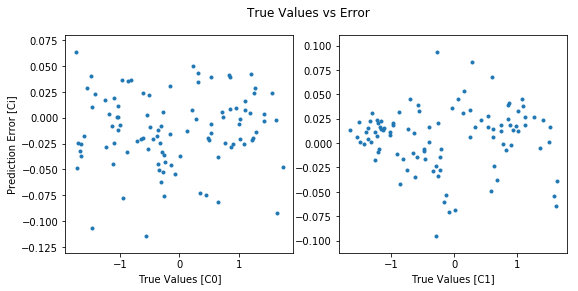

In [191]:
plot_true_v_error(normed_test_Ci_df_25, error_10_1_25)

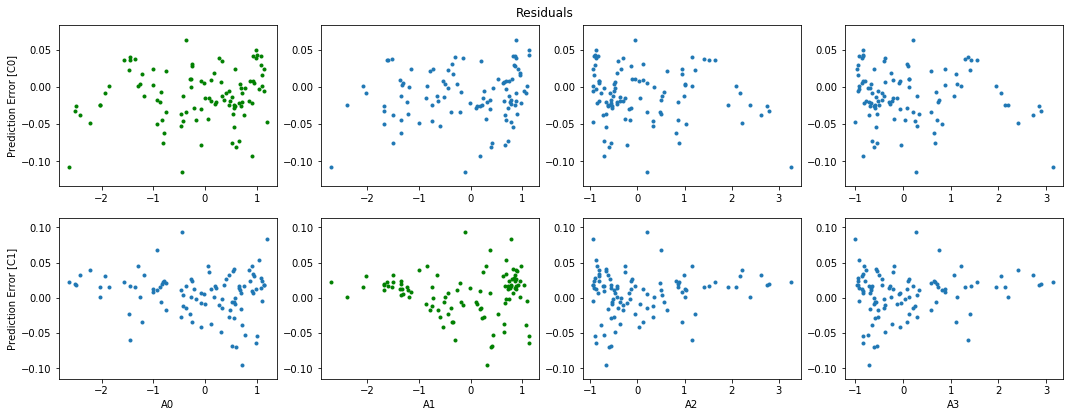

In [192]:
plot_residuals(normed_test_Am_df_25, error_10_1_25, green_list=[(0,0),(1,1),(2,2),(3,3)])

In [193]:
loss_10_1_25L, mae_10_1_25L, mse_10_1_25L = \
model_10_1_25.evaluate(large_normed_test_Am_df_25, large_normed_test_Ci_df_25, \
                        verbose=2)

1600/1600 - 0s - loss: 0.0016 - mae: 0.0308 - mse: 0.0016


In [194]:
# Scaled MAE
test_predictions_10_1_25L = model_10_1_25.predict(large_normed_test_Am_df_25)
error_10_1_25L = test_predictions_10_1_25L - large_normed_test_Ci_df_25
scaled_mae_10_1_25L = error_10_1_25L.abs().mean()*train_Ci_stats_25['std']
print(scaled_mae_10_1_25L)

C0    2.962896e-08
C1    2.396276e-08
dtype: float64


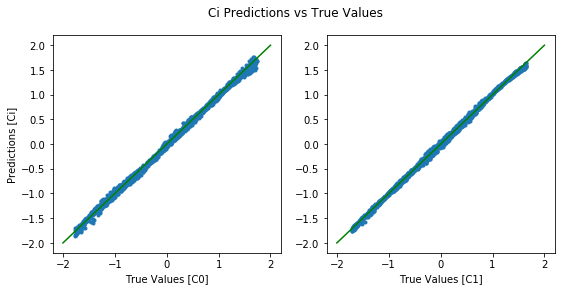

In [195]:
plot_predict(test_predictions_10_1_25L, large_normed_test_Ci_df_25, lims=[-2,2])

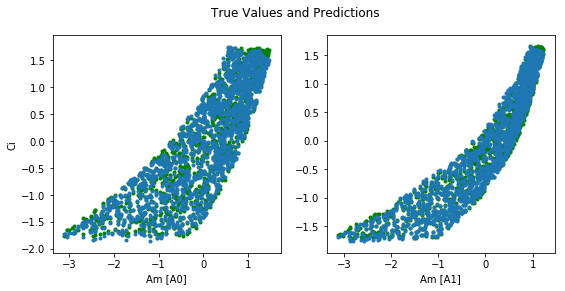

In [196]:
plot_true_and_pred(large_normed_test_Ci_df_25, test_predictions_10_1_25L, \
                   large_normed_test_Am_df_25)

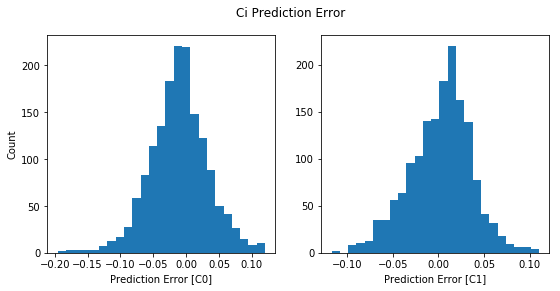

In [197]:
plot_error_hist(error_10_1_25L)

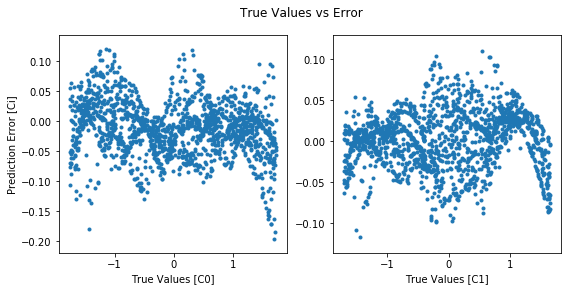

In [198]:
plot_true_v_error(large_normed_test_Ci_df_25, error_10_1_25L)

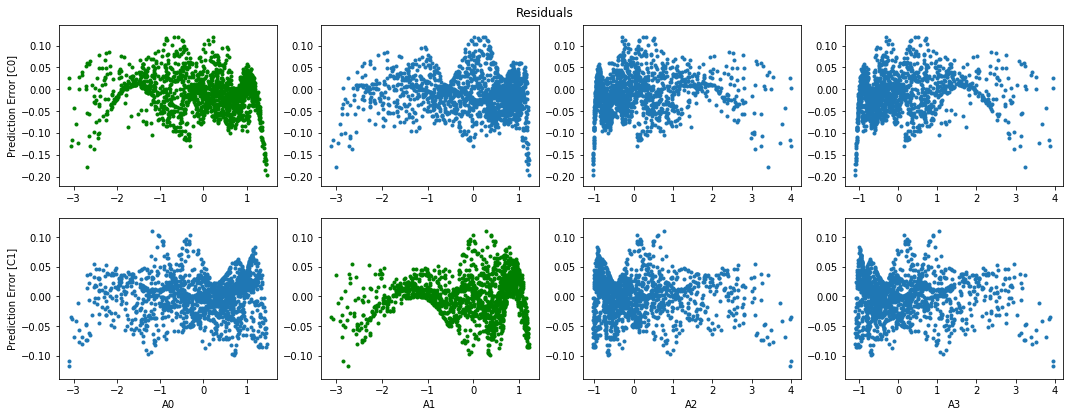

In [199]:
plot_residuals(large_normed_test_Am_df_25, error_10_1_25L, \
               green_list=[(0,0),(1,1),(2,2),(3,3)])

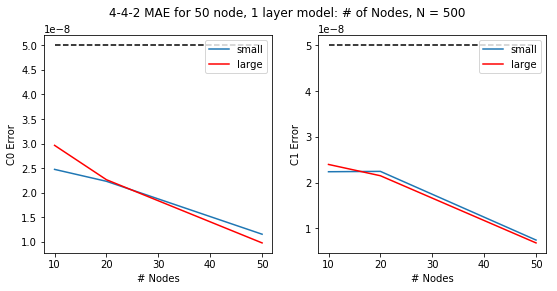

In [200]:
fig, ax = plt.subplots(1,2,figsize=(9,4))
fig.suptitle('4-4-2 MAE for 50 node, 1 layer model: # of Nodes, N = 500')
for i in range(2):
    ax[i].plot([50,20,10],\
             [scaled_mae_50_1_25[i], scaled_mae_20_1_25[i], scaled_mae_10_1_25[i]], \
              label='small')
    ax[i].plot([50,20,10],\
             [scaled_mae_50_1_25L[i], scaled_mae_20_1_25L[i], scaled_mae_10_1_25L[i]],\
             'r', label='large')
#     ax[i].plot([10,50],[1e-7,1e-7],'k--')
    ax[i].plot([10,50],[5e-8,5e-8],'k--')
    ax[i].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax[i].legend(loc='upper right')
    ax[i].set_xlabel('# Nodes')
    ax[i].set_ylabel('C{} Error'.format(i))
#     ax[i].set_ylim(0,1.5e-7)